# Análisis tramas BLE

## Introducción

Primer acercamiento al análisis de los datos generados por un módulo ESP32 encargado de capturar las tramas Bluetooth generadas por los dispositivos cercanos.
Este estudio tiene como objetivo identificar patrones en los que se relacionan los datos para así poder aplicar algoritmos de Machine Learning para ser capaz de predecir el número de personas en un recinto.

En primer, cargaremos un datasheet generado por los receptores y por otro sensor colocado en la entrada de la biblioteca capaz de contabilizar el número de personas que entran y salen. Veremos que aspecto tienen los datos:

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#!pip install dython

In [4]:
import os
import pathlib
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from dython.nominal import associations
from sklearn.metrics import mean_squared_error
import math

In [5]:
"""
data_20220712 = pd.read_csv('/content/drive/MyDrive/UPCT/docs/data/ble-filter-clean-P_2022-07-12.csv', sep=';')
data_20220713 = pd.read_csv('/content/drive/MyDrive/UPCT/docs/data/ble-filter-clean-P_2022-07-13.csv', sep=';')
data_20220714 = pd.read_csv('/content/drive/MyDrive/UPCT/docs/data/ble-filter-clean-P_2022-07-14.csv', sep=';')
data_20220715 = pd.read_csv('/content/drive/MyDrive/UPCT/docs/data/ble-filter-clean-P_2022-07-15.csv', sep=';')
personCount_20220712 = pd.read_csv('/content/drive/MyDrive/UPCT/docs/personcount/PersonCount_2022-07-12_7-22.csv', sep=';')
personCount_20220713 = pd.read_csv('/content/drive/MyDrive/UPCT/docs/personcount/PersonCount_2022-07-13_7-22.csv', sep=';')
personCount_20220714 = pd.read_csv('/content/drive/MyDrive/UPCT/docs/personcount/PersonCount_2022-07-14_7-22.csv', sep=';')
personCount_20220715 = pd.read_csv('/content/drive/MyDrive/UPCT/docs/personcount/PersonCount_2022-07-15_7-22.csv', sep=';')
"""
data_20220712 = pd.read_csv('docs/data/ble-filter-clean-P_2022-07-12.csv', sep=';')
data_20220713 = pd.read_csv('docs/data/ble-filter-clean-P_2022-07-13.csv', sep=';')
data_20220714 = pd.read_csv('docs/data/ble-filter-clean-P_2022-07-14.csv', sep=';')
data_20220715 = pd.read_csv('docs/data/ble-filter-clean-P_2022-07-15.csv', sep=';')
personCount_20220712 = pd.read_csv('docs/personcount/PersonCount_2022-07-12_7-22.csv', sep=';')
personCount_20220713 = pd.read_csv('docs/personcount/PersonCount_2022-07-13_7-22.csv', sep=';')
personCount_20220714 = pd.read_csv('docs/personcount/PersonCount_2022-07-14_7-22.csv', sep=';')
personCount_20220715 = pd.read_csv('docs/personcount/PersonCount_2022-07-15_7-22.csv', sep=';')

In [ ]:
def transformTimestampPersonCount(personCount):
    """Función que transforma los campos Fecha y Hora del conjunto de dato proporcionado por el contador de personas a un Timestamp usable"""

    timestamp = []
    for i in range(len(personCount)):
        timestamp.append(personCount['Fecha'][i] + ' ' + personCount['Hora'][i])
    personCount["Timestamp"] = pd.to_datetime(timestamp, dayfirst=True)
    return personCount

def transformTimestamp(data, personCount):
    """Función que transforma los campos Fecha y Hora del conjunto de dato proporcionado por el contador de personas y del contador de dispositivos a un Timestamp usable"""

    timestamp = []
    for i in range(len(personCount)):
        timestamp.append(personCount['Fecha'][i] + ' ' + personCount['Hora'][i])
    personCount["Timestamp"] = pd.to_datetime(timestamp, dayfirst=True)
    data["Timestamp int."] = pd.to_datetime(data["Timestamp int."], dayfirst=True)
    data = data.rename(columns={"Timestamp int.": "Timestamp"})
    return data, personCount

def parseData(time, data):
    """Función que recibe un Dataframe con datos BLE agrupados y devuelve un Dataframe con las mismas columnas pero con el Timestamp completo"""

    columns = data.columns.values
    columnsFull = np.append(columns, "Timestamp")
    fullData = pd.DataFrame(columns=columns)
    for i in range(len(time)):
        if len(data.loc[data.index == time[i]]) == 0:
            if i == 0:
                df = pd.DataFrame([np.zeros(len(columns)).astype(int)], columns=columns)
                df["Timestamp"] = time[i]
                fullData = pd.concat([fullData, df])
            elif i == len(time)-1:
                df = pd.DataFrame(data.loc[data.index == time[i-1]].values, columns=columns)
                df["Timestamp"] = time[i]
                fullData = pd.concat([fullData, df])
            else:
                if len(data.loc[data.index == time[i+1]]) == 0:
                    df = pd.DataFrame(fullData.loc[fullData.Timestamp == time[i-1]].values, columns=columnsFull)
                else:
                    dataPre = fullData.loc[fullData.Timestamp == time[i-1]]
                    dataPre = dataPre.loc[:, dataPre.columns != "Timestamp"].values[0]
                    dataPost = data.loc[data.index == time[i+1]].values[0]
                    array = np.array([dataPre, dataPost], dtype=object)
                    row = np.mean(array, axis=0).astype(int)
                    df = pd.DataFrame([row], columns=columns)
                df["Timestamp"] = time[i]
                fullData = pd.concat([fullData, df])
        else:
            df = pd.DataFrame(data.loc[data.index == time[i]].values, columns=columns)
            df["Timestamp"] = time[i]
            fullData = pd.concat([fullData, df])
    fullData.set_index("Timestamp", inplace=True)

    return fullData

def parsePersonCount(time, personCount):
    """Función que devuelve un Dataframe con una columna Timestamp y otra columna con el número de personas detectadas por el contador de personas"""

    zeroList = pd.Series(np.zeros(len(time)))
    fullPersonCountInterval = pd.DataFrame({'Timestamp': pd.to_datetime(time), 'personCount': zeroList})
    personCountInterval = personCount.groupby(pd.Grouper(key='Timestamp', freq='5T'))["Estimación nº Personas"].last()
    booleanPersonCountInterval = personCountInterval.isna()

    for i in range(len(personCountInterval)):
        if booleanPersonCountInterval[i]:
            personCountInterval[i] = personCountInterval[i-1]

    for i in range(len(time)):
        if len(personCountInterval.loc[personCountInterval.index == fullPersonCountInterval["Timestamp"][i]]) != 0:
            if personCountInterval.loc[personCountInterval.index == fullPersonCountInterval["Timestamp"][i]][0] < 0:
                nPeople = 0
            else:
                nPeople = personCountInterval.loc[personCountInterval.index == fullPersonCountInterval["Timestamp"][i]][0]
            fullPersonCountInterval["personCount"][i] = int(nPeople)

    return fullPersonCountInterval

def generateTimeSeries(data):
    """Función que devuelve una Serie con un Timestamp espaciado según el conjunto de datos pasado como parámetro"""

    timeSeries = pd.Series(pd.date_range(data["Timestamp"].iloc[0], data["Timestamp"].iloc[-1], freq='5T'))
    return timeSeries

def generateTimeSeriesByHour(data, initHour='7:00:00', endHour='21:55:00'):
    """Función que devuelve una Serie con un Timestamp espaciado en intervalos de 5 minutos dada una hora de comienzo y de fin"""
    date =  data["Timestamp"][0].date()
    start = str(date) + " " + initHour
    end = str(date) + " " + endHour
    timeSeries = pd.Series(pd.date_range(start, end, freq='5T'))
    return timeSeries

def uniqueValues(data):
    """Función que imprime el total de valores únicos de cada columna del conjunto de datos"""

    print(data.nunique().sort_values())
    print('')
    print('Número de filas total: ', data.shape[0])

def readDataFromDirectory(dataPath, fullPersonCountPath):
    """Función que lee los archivos de datos de los receptores Bluetooth y del contador de personas y los concentra en un array"""

    dataArray = []
    fullPersonCountIntervalArray = []
    contentPersonCountDirectory = os.listdir(fullPersonCountPath)
    dataPath = pathlib.Path(dataPath)
    for file in dataPath.iterdir():
        data = pd.read_csv(file, sep=';')
        data["Timestamp int."] = pd.to_datetime(data["Timestamp int."], dayfirst=True)
        data = data.rename(columns={"Timestamp int.": "Timestamp"})
        dataArray.append(data)

    for file in range(len(contentPersonCountDirectory)):
        personCount = pd.read_csv(fullPersonCountPath+contentPersonCountDirectory[file], sep=';')
        personCount = transformTimestampPersonCount(personCount)
        time = generateTimeSeriesByHour(dataArray[file])
        fullPersonCount = parsePersonCount(time, personCount)
        fullPersonCountIntervalArray.append(fullPersonCount)

    return dataArray, fullPersonCountIntervalArray

def totalDevicesSummary(data):
    """Función que imprime un resumen del número total de dispositivos captados globalmente y por Raspberry"""

    MACTypeData = data.groupby(pd.Grouper(key='Raspberry')).nunique()["MAC"].sort_index()
    sumTotalDevices = 0
    for i in range(np.shape(MACTypeData)[0]):
        print('Número de dispositivos captados por la', MACTypeData.index[i], ':', MACTypeData[i])
        sumTotalDevices = sumTotalDevices + MACTypeData[i]
    totalDevices = len(data.MAC.unique())
    print('Sumatorio del número total de dispositivos captados por cada receptor:', sumTotalDevices)
    print('Número total de dispositivos captados:', totalDevices)

def plotRandomPublicMAC(data):
    """Función que representa un histograma con la cantidad de dispositivos con MAC Random y Pública"""

    MACTypeData = data.groupby(pd.Grouper(key='Tipo MAC')).nunique()
    plt.bar(MACTypeData.index, MACTypeData.MAC)
    plt.xlabel("MAC Address Type")
    plt.ylabel("MAC Address's Number")
    plt.title("Random vs Public MAC Address")
    plt.show()

def plotTotalDevices(data, fullPersonCountInterval):
    """Función que representa el número de dispositivos únicos captados en cada intervalo de tiempo"""

    nDevicesInterval = data.groupby(pd.Grouper(key='Timestamp')).nunique()
    nDevicesIntervalRand = data.loc[data['Tipo MAC'] == 'Random']
    nDevicesIntervalRand = nDevicesIntervalRand.groupby(pd.Grouper(key='Timestamp')).nunique()
    plt.figure(figsize=(10,6))
    plt.plot(nDevicesInterval.index, nDevicesInterval["MAC"], color='blue', label='Public+Random')
    plt.plot(nDevicesIntervalRand.index, nDevicesIntervalRand["MAC"], color='green', label='Random')
    plt.plot(fullPersonCountInterval["Timestamp"], fullPersonCountInterval["personCount"], color='red', label='Person Count')
    plt.xlabel("Timestamp")
    plt.ylabel("Devices and People")
    plt.title("Device's Number along Time "+fullPersonCountInterval["Timestamp"][0].strftime('%Y-%m-%d'))
    plt.legend()
    plt.show()

def getDatasheet(data, rand):
    """Función que devuelve un conjunto de datos filtrado por tipo de MAC Random o el conjunto completo"""

    if rand:
        nDevicesInterval = data.loc[data['Tipo MAC'] == 'Random']
    else:
        nDevicesInterval = data
    return nDevicesInterval

def parseDataByRaspberry(data, rand=False):
    """Función que devuelve un conjunto de datos filtrado por cada Raspberry. Devuelve un conjunto por Raspberry.
    Se le puede indicar usar todo el conjunto o solamente las MAC Random"""

    nDevicesInterval = getDatasheet(data, rand)
    dataInterval1 = nDevicesInterval.loc[nDevicesInterval['Raspberry'] == 'Raspberry1']
    dataInterval2 = nDevicesInterval.loc[nDevicesInterval['Raspberry'] == 'Raspberry2']
    dataInterval3 = nDevicesInterval.loc[nDevicesInterval['Raspberry'] == 'Raspberry3']
    dataInterval4 = nDevicesInterval.loc[nDevicesInterval['Raspberry'] == 'Raspberry5']
    dataInterval5 = nDevicesInterval.loc[nDevicesInterval['Raspberry'] == 'Raspberry7']
    return dataInterval1, dataInterval2, dataInterval3, dataInterval4, dataInterval5

def parseDataByRaspberryTime(data, rand=False):
    """Función que devuelve conjuntos de datos con valores únicos filtrados por Raspberry y agrupados por Timestamp"""

    dataInterval1, dataInterval2, dataInterval3, dataInterval4, dataInterval5 = parseDataByRaspberry(data, rand)
    dataInterval1 = dataInterval1.groupby(['Timestamp']).nunique()
    dataInterval2 = dataInterval2.groupby(['Timestamp']).nunique()
    dataInterval3 = dataInterval3.groupby(['Timestamp']).nunique()
    dataInterval4 = dataInterval4.groupby(['Timestamp']).nunique()
    dataInterval5 = dataInterval5.groupby(['Timestamp']).nunique()
    return dataInterval1, dataInterval2, dataInterval3, dataInterval4, dataInterval5

def getDeviceNumberByRaspberry(data, rand):
    """Función que devuelve el número de dispositivos en cada intervalo de tiempo para cada Raspberry"""

    dataInterval1, dataInterval2, dataInterval3, dataInterval4, dataInterval5 = parseDataByRaspberryTime(data, rand)
    nDevicesRaspberry1 = len(dataInterval1.groupby("MAC").count())
    nDevicesRaspberry2 = len(dataInterval2.groupby("MAC").count())
    nDevicesRaspberry3 = len(dataInterval3.groupby("MAC").count())
    nDevicesRaspberry4 = len(dataInterval4.groupby("MAC").count())
    nDevicesRaspberry5 = len(dataInterval5.groupby("MAC").count())
    return nDevicesRaspberry1, nDevicesRaspberry2, nDevicesRaspberry3, nDevicesRaspberry4, nDevicesRaspberry5

def plotTotalDevicesByRaspberry(data, fullPersonCountInterval, rand=False, initHour=None, endHour=None):
    """Función que representa el número de dispositivos en cada intervalo de tiempo para cada Raspberry"""

    nDevicesIntervalDataRaspberry1, nDevicesIntervalDataRaspberry2, nDevicesIntervalDataRaspberry3, nDevicesIntervalDataRaspberry5, nDevicesIntervalDataRaspberry7 = parseDataByRaspberryTime(data, rand)
    plt.figure(figsize=(10,6))
    plt.plot(nDevicesIntervalDataRaspberry1.index, nDevicesIntervalDataRaspberry1.MAC, color='blue', label='Raspberry1')
    plt.plot(nDevicesIntervalDataRaspberry2.index, nDevicesIntervalDataRaspberry2.MAC, color='green', label='Raspberry2')
    plt.plot(nDevicesIntervalDataRaspberry3.index, nDevicesIntervalDataRaspberry3.MAC, color='purple', label='Raspberry3')
    plt.plot(nDevicesIntervalDataRaspberry5.index, nDevicesIntervalDataRaspberry5.MAC, color='deeppink', label='Raspberry5')
    plt.plot(nDevicesIntervalDataRaspberry7.index, nDevicesIntervalDataRaspberry7.MAC, color='gold', label='Raspberry7')
    plt.plot(fullPersonCountInterval.Timestamp, fullPersonCountInterval.personCount, color='red', label='Person Count')
    plt.xlabel("Timestamp")
    plt.ylabel("Devices and People")
    plt.title("Device's Number along Time per Raspberry")
    if (initHour is not None) and (endHour is not None):
        initialDate = dt.datetime(data['Timestamp'][0].year, data['Timestamp'][0].month, data['Timestamp'][0].day, hour=initHour)
        finalDate = dt.datetime(data['Timestamp'][0].year, data['Timestamp'][0].month, data['Timestamp'][0].day, hour=endHour)
        plt.xlim(initialDate, finalDate)
    plt.legend()
    plt.show()

def errorCalc(data, fullPersonCountInterval, rand=False, startHour='8:00:00', finalHour='21:00:00', show=True):
    """Función que devuelve el error medio, el error cuadrático medio y la varianza entre el número de dispositivos captados y el número de personas contadas por el contador de personas"""

    nDevicesInterval = getDatasheet(data, rand)
    timeSeries = generateTimeSeriesByHour(nDevicesInterval)
    nDevicesInterval = nDevicesInterval.groupby(pd.Grouper(key='Timestamp')).nunique()
    nDevicesInterval = parseData(timeSeries, nDevicesInterval)
    date = nDevicesInterval.index[0].date().strftime('%Y-%m-%d')
    init = date + ' ' + startHour
    end = date + ' ' + finalHour
    nDevicesInterval = nDevicesInterval.loc[init:end]
    fullPersonCountInterval = fullPersonCountInterval.loc[(fullPersonCountInterval["Timestamp"] >= init) & (fullPersonCountInterval["Timestamp"] <= end)]
    errorInterval = nDevicesInterval["MAC"].values - fullPersonCountInterval["personCount"]
    error = np.round(errorInterval.mean(), 3)
    quadraticError = np.round(mean_squared_error(nDevicesInterval["MAC"].values, fullPersonCountInterval["personCount"]),3)
    variance = np.round(np.var(errorInterval))
    if show:
        print("El error medio del día es:", error)
        print("El error cuadrático medio del día es:", quadraticError)
        print("La varianza del error del día es:", variance)
    return error, quadraticError, variance

def errorCalcList(dataArray, fullPersonCountIntervalArray, rand=False, startHour='8:00:00', finalHour='21:00:00', show=False):
    """Función que devuelve el error medio, el error cuadrático medio y la varianza entre el número de dispositivos captados y el número de personas contadas por el contador de personas para un array de días en forma de tabla"""

    errorMetrics = pd.DataFrame(columns=["Date", "Start Hour", "End Hour", "Error", "Quadratic Error", "Variance"])
    for i in range(len(dataArray)):
        deviceDataframe = dataArray[i]
        personDataframe = fullPersonCountIntervalArray[i]
        error, quadraticError, variance = errorCalc(deviceDataframe, personDataframe, rand, startHour, finalHour, show)
        df = pd.DataFrame([[deviceDataframe["Timestamp"][0].date(), startHour, finalHour, error, quadraticError, variance]],
                          columns=["Date", "Start Hour", "End Hour", "Error", "Quadratic Error", "Variance"])
        errorMetrics = pd.concat([errorMetrics, df], ignore_index=True)
    print(errorMetrics)
    return errorMetrics

def tableMetricList(dataArray, fullPersonCountIntervalArray, rand=False, startHour='8:00:00', finalHour='21:00:00', show=False, firstValue='7:00:00', secondValue='21:30:00', interval=30, threshold=70, offset=False, showDetail=False):
    tableMetrics = pd.DataFrame(columns=["Date", "Start Hour", "End Hour", "Error", "Ratio", "Offset"])
    for i in range(len(dataArray)):
        deviceDataframe = dataArray[i]
        personDataframe = fullPersonCountIntervalArray[i]
        error, _, _ = errorCalc(deviceDataframe, personDataframe, rand, startHour, finalHour, show)
        _, ratio = deviceRatio(deviceDataframe, personDataframe, rand, startHour, finalHour, show, offset, firstValue, secondValue, interval, threshold, showDetail)
        _, devicesFirstHour, _, devicesSecondHour = devicesOffset(deviceDataframe, rand, firstValue, secondValue, interval, threshold, show)
        df = pd.DataFrame([[deviceDataframe["Timestamp"][0].date(), startHour, finalHour, error, ratio, np.round(np.mean([devicesFirstHour, devicesSecondHour]))]],
                          columns=["Date", "Start Hour", "End Hour", "Error", "Ratio", "Offset"])
        tableMetrics = pd.concat([tableMetrics, df], ignore_index=True)
    print(tableMetrics)
    return tableMetrics

def rssiCalc(data, rand=False, initValue=10, endValue=50):
    """Función que calcula el número de dispositivos cuyos mensajes se encuentran en unos umbrales de potencia modificables"""

    nDevicesInterval = getDatasheet(data, rand)
    minRSSI = nDevicesInterval["RSSI promedio"].min()
    values = np.round(np.linspace(initValue, endValue, 5)/100,2)

    rssiDeviceInterval1 = nDevicesInterval.loc[(nDevicesInterval["RSSI promedio"] <= minRSSI - minRSSI*values[0])]
    nDevices1 = rssiDeviceInterval1.groupby("MAC").count()
    rssiDeviceInterval1 = rssiDeviceInterval1.groupby("Timestamp").count()

    rssiDeviceInterval2 = nDevicesInterval.loc[(nDevicesInterval["RSSI promedio"] > minRSSI - minRSSI*values[0]) & (nDevicesInterval["RSSI promedio"] <= minRSSI - minRSSI*values[1])]
    nDevices2 = rssiDeviceInterval2.groupby("MAC").count()
    rssiDeviceInterval2 = rssiDeviceInterval2.groupby("Timestamp").count()

    rssiDeviceInterval3 = nDevicesInterval.loc[(nDevicesInterval["RSSI promedio"] > minRSSI - minRSSI*values[1]) & (nDevicesInterval["RSSI promedio"] <= minRSSI - minRSSI*values[2])]
    nDevices3 = rssiDeviceInterval3.groupby("MAC").count()
    rssiDeviceInterval3 = rssiDeviceInterval3.groupby("Timestamp").count()

    rssiDeviceInterval4 = nDevicesInterval.loc[(nDevicesInterval["RSSI promedio"] > minRSSI - minRSSI*values[2]) & (nDevicesInterval["RSSI promedio"] <= minRSSI - minRSSI*values[3])]
    nDevices4 = rssiDeviceInterval4.groupby("MAC").count()
    rssiDeviceInterval4 = rssiDeviceInterval4.groupby("Timestamp").count()

    rssiDeviceInterval5 = nDevicesInterval.loc[(nDevicesInterval["RSSI promedio"] > minRSSI - minRSSI*values[3]) & (nDevicesInterval["RSSI promedio"] <= minRSSI - minRSSI*values[4])]
    nDevices5 = rssiDeviceInterval5.groupby("MAC").count()
    rssiDeviceInterval5 = rssiDeviceInterval5.groupby("Timestamp").count()

    rssiDeviceInterval6 = nDevicesInterval.loc[nDevicesInterval["RSSI promedio"] > minRSSI - minRSSI*values[4]]
    nDevices6 = rssiDeviceInterval6.groupby("MAC").count()
    rssiDeviceInterval6 = rssiDeviceInterval6.groupby("Timestamp").count()

    return rssiDeviceInterval1, rssiDeviceInterval2, rssiDeviceInterval3, rssiDeviceInterval4, rssiDeviceInterval5, rssiDeviceInterval6, values*100

def plotTotalDevicesByRSSI(data, rand=False, initValue=10, endValue=50):
    """Función que representa el número de dispositivos cuyos mensajes se encuentran en unos umbrales de potencia modificables"""

    rssiDeviceInterval1, rssiDeviceInterval2, rssiDeviceInterval3, rssiDeviceInterval4, rssiDeviceInterval5, rssiDeviceInterval6, values = rssiCalc(data, rand, initValue, endValue)
    plt.figure(figsize=(10,6))
    plt.plot(rssiDeviceInterval1.index, rssiDeviceInterval1.MAC, color='blue', label='RSSI <= '+str(values[0])+'%')
    plt.plot(rssiDeviceInterval2.index, rssiDeviceInterval2.MAC, color='green', label=str(values[0])+'% < RSSI <= '+str(values[1])+'%')
    plt.plot(rssiDeviceInterval3.index, rssiDeviceInterval3.MAC, color='purple', label=str(values[1])+'% < RSSI <= '+str(values[2])+'%')
    plt.plot(rssiDeviceInterval4.index, rssiDeviceInterval4.MAC, color='deeppink', label=str(values[2])+'% < RSSI <= '+str(values[3])+'%')
    plt.plot(rssiDeviceInterval5.index, rssiDeviceInterval5.MAC, color='gold', label=str(values[3])+'% < RSSI <= '+str(values[4])+'%')
    plt.plot(rssiDeviceInterval6.index, rssiDeviceInterval6.MAC, color='red', label=str(values[4])+'% < RSSI')
    plt.xlabel("Timestamp")
    plt.ylabel("Device's Number")
    plt.title("Device's Number by RSSI Level")
    plt.legend()
    plt.show()

def histTotalDevicesByRSSIAndRaspberry(data, rand=False, bins=20):
    """Función que representa en forma de histograma la cantidad de dispositivos comprendidos entre el nivel de señal mínimo y máximo"""

    nDevicesInterval = getDatasheet(data, rand)
    rssiDeviceInterval1, rssiDeviceInterval2, rssiDeviceInterval3, rssiDeviceInterval4, rssiDeviceInterval5 = parseDataByRaspberry(nDevicesInterval)

    rssiDeviceInterval1 = rssiDeviceInterval1.groupby(pd.Grouper(key='MAC')).mean()
    rssiDeviceInterval2 = rssiDeviceInterval2.groupby(pd.Grouper(key='MAC')).mean()
    rssiDeviceInterval3 = rssiDeviceInterval3.groupby(pd.Grouper(key='MAC')).mean()
    rssiDeviceInterval4 = rssiDeviceInterval4.groupby(pd.Grouper(key='MAC')).mean()
    rssiDeviceInterval5 = rssiDeviceInterval5.groupby(pd.Grouper(key='MAC')).mean()

    figure, axis = plt.subplots(5, 1, sharex=True, sharey=True)
    figure.set_size_inches(10,15)
    axis[0].hist(rssiDeviceInterval1['RSSI promedio'], bins, color='blue')
    axis[0].set_title("Raspberry1")
    axis[1].hist(rssiDeviceInterval2['RSSI promedio'], bins, color='green')
    axis[1].set_title("Raspberry2")
    axis[2].hist(rssiDeviceInterval3['RSSI promedio'], bins, color='red')
    axis[2].set_title("Raspberry3")
    axis[3].hist(rssiDeviceInterval4['RSSI promedio'], bins, color='deeppink')
    axis[3].set_title("Raspberry5")
    axis[4].hist(rssiDeviceInterval5['RSSI promedio'], bins, color='gold')
    axis[4].set_title("Raspberry7")

def messageCalc(data, rand=False, initValue=25, endValue=125):
    """Función que devuelve el número de dispositivos que se encuentran en unos umbrales en función del número de mensajes en cada intervalo de tiempo"""

    nDevicesInterval = getDatasheet(data, rand)
    values = np.linspace(initValue, endValue, 5)
    values = values.astype(int)

    messageDeviceInterval1 = nDevicesInterval.loc[(nDevicesInterval["Nº Mensajes"] <= values[0])]
    nDevices1 = messageDeviceInterval1.groupby("MAC").count()
    messageDeviceInterval1 = messageDeviceInterval1.groupby("Timestamp").count()

    messageDeviceInterval2 = nDevicesInterval.loc[(nDevicesInterval["Nº Mensajes"] > values[0]) & (nDevicesInterval["Nº Mensajes"] <= values[1])]
    nDevices2 = messageDeviceInterval2.groupby("MAC").count()
    messageDeviceInterval2 = messageDeviceInterval2.groupby("Timestamp").count()

    messageDeviceInterval3 = nDevicesInterval.loc[(nDevicesInterval["Nº Mensajes"] > values[1]) & (nDevicesInterval["Nº Mensajes"] <= values[2])]
    nDevices3 = messageDeviceInterval3.groupby("MAC").count()
    messageDeviceInterval3 = messageDeviceInterval3.groupby("Timestamp").count()

    messageDeviceInterval4 = nDevicesInterval.loc[(nDevicesInterval["Nº Mensajes"] > values[2]) & (nDevicesInterval["Nº Mensajes"] <= values[3])]
    nDevices4 = messageDeviceInterval4.groupby("MAC").count()
    messageDeviceInterval4 = messageDeviceInterval4.groupby("Timestamp").count()

    messageDeviceInterval5 = nDevicesInterval.loc[(nDevicesInterval["Nº Mensajes"] > values[3]) & (nDevicesInterval["Nº Mensajes"] <= values[4])]
    nDevices5 = messageDeviceInterval5.groupby("MAC").count()
    messageDeviceInterval5 = messageDeviceInterval5.groupby("Timestamp").count()

    messageDeviceInterval6 = nDevicesInterval.loc[nDevicesInterval["Nº Mensajes"] > values[4]]
    nDevices6 = messageDeviceInterval6.groupby("MAC").count()
    messageDeviceInterval6 = messageDeviceInterval6.groupby("Timestamp").count()

    return messageDeviceInterval1, messageDeviceInterval2, messageDeviceInterval3, messageDeviceInterval4, messageDeviceInterval5, messageDeviceInterval6, values

def plotTotalDevicesByMessage(data, fullPersonCountInterval, rand=False, initValue=25, endValue=125, name=None):
    """Función que representa el número de dispositivos que se encuentran en unos umbrales en función del número de mensajes en cada intervalo de tiempo"""

    messageDeviceInterval1, messageDeviceInterval2, messageDeviceInterval3, messageDeviceInterval4, messageDeviceInterval5, messageDeviceInterval6, values = messageCalc(data, rand, initValue, endValue)
    values = values.astype(str)
    plt.figure(figsize=(10,6))
    plt.plot(messageDeviceInterval1.index, messageDeviceInterval1['Nº Mensajes'], color='blue', label=' nMessage <= '+values[0])
    plt.plot(messageDeviceInterval2.index, messageDeviceInterval2['Nº Mensajes'], color='green', label=values[0]+' < nMessage <= '+values[1])
    plt.plot(messageDeviceInterval3.index, messageDeviceInterval3['Nº Mensajes'], color='purple', label=values[1]+' < nMessage <= '+values[2])
    plt.plot(messageDeviceInterval4.index, messageDeviceInterval4['Nº Mensajes'], color='deeppink', label=values[2]+' < nMessage <= '+values[3])
    plt.plot(messageDeviceInterval5.index, messageDeviceInterval5['Nº Mensajes'], color='gold', label=values[3]+' < nMessage <= '+values[4])
    plt.plot(messageDeviceInterval6.index, messageDeviceInterval6['Nº Mensajes'], color='red', label=values[4]+' < nMessage')
    plt.plot(fullPersonCountInterval.Timestamp, fullPersonCountInterval.personCount, color='cyan', label='Person Count')
    plt.xlabel("Timestamp")
    plt.ylabel("Device's Number")
    if name is None:
        plt.title("Number of Devices by Message's Number")
    else:
        plt.title("Number of Devices by Message's Number in "+name)
    plt.legend()
    plt.show()

def plotTotalDevicesByMessageByRaspberry(data, fullPersonCountInterval, rand=False, initValue=25, endValue=125):
    """Función que representa el número de dispositivos que se encuentran en unos umbrales en función del número de mensajes en cada intervalo de tiempo para cada una de las Raspberries"""

    dataInterval1, dataInterval2, dataInterval3, dataInterval4, dataInterval5 = parseDataByRaspberry(data, rand)
    plotTotalDevicesByMessage(dataInterval1, fullPersonCountInterval, rand, initValue, endValue, "Raspberry1")
    plotTotalDevicesByMessage(dataInterval2, fullPersonCountInterval, rand, initValue, endValue, "Raspberry2")
    plotTotalDevicesByMessage(dataInterval3, fullPersonCountInterval, rand, initValue, endValue, "Raspberry3")
    plotTotalDevicesByMessage(dataInterval4, fullPersonCountInterval, rand, initValue, endValue, "Raspberry5")
    plotTotalDevicesByMessage(dataInterval5, fullPersonCountInterval, rand, initValue, endValue, "Raspberry7")

def getMetricsRoom(data, rand=False, RSSIThreshold=-99):
    """Función que muestra métricas únicamente de la sala de estudio, como número de dispositivos captados por Raspberry, número de mensajes captados por Raspberry, tanto por ciento de dispositivos con mensajes por debajo de cierto umbral de mensajes y tanto por ciento de dispositivos con mensajes por debajo de cierto umbral de potencia"""

    _, nDevicesInterval2, _, nDevicesInterval4, nDevicesInterval5 = parseDataByRaspberry(data, rand)
    _, nDevicesRaspberry2, _, nDevicesRaspberry4, nDevicesRaspberry5 = getDeviceNumberByRaspberry(data, rand)
    print("Número dispositivos captados por la Raspberry2:", nDevicesRaspberry2)
    print("Número dispositivos captados por la Raspberry5:", nDevicesRaspberry4)
    print("Número dispositivos captados por la Raspberry7:", nDevicesRaspberry5)
    print('')

    nMessageRaspberry2 = nDevicesInterval2["Nº Mensajes"].sum()
    nMessageRaspberry5 = nDevicesInterval4["Nº Mensajes"].sum()
    nMessageRaspberry7 = nDevicesInterval5["Nº Mensajes"].sum()
    print("Número de mensajes captados por la Raspberry2:", nMessageRaspberry2)
    print("Número de mensajes captados por la Raspberry5:", nMessageRaspberry5)
    print("Número de mensajes captados por la Raspberry7:", nMessageRaspberry7)
    print('')

    filterRaspberry2 = nDevicesInterval2.loc[nDevicesInterval2["RSSI promedio"] < RSSIThreshold]
    nMessageFilterRaspberry2 = filterRaspberry2["Nº Mensajes"].sum()

    filterRaspberry5 = nDevicesInterval4.loc[nDevicesInterval4["RSSI promedio"] < RSSIThreshold]
    nMessageFilterRaspberry5 = filterRaspberry5["Nº Mensajes"].sum()

    filterRaspberry7 = nDevicesInterval5.loc[nDevicesInterval5["RSSI promedio"] < RSSIThreshold]
    nMessageFilterRaspberry7 = filterRaspberry7["Nº Mensajes"].sum()

    print("Tanto por ciento de mensajes por debajo de "+str(RSSIThreshold)+" dB en Raspberry2:", np.round(nMessageFilterRaspberry2/nMessageRaspberry2*100, 4), "%")
    print("Tanto por ciento de mensajes por debajo de "+str(RSSIThreshold)+" dB en Raspberry5:", np.round(nMessageFilterRaspberry5/nMessageRaspberry5*100, 4), "%")
    print("Tanto por ciento de mensajes por debajo de "+str(RSSIThreshold)+" dB en Raspberry7:", np.round(nMessageFilterRaspberry7/nMessageRaspberry7*100, 4), "%")
    print('')

    nDeviceRaspberry2 = nDevicesInterval2["MAC"].count()
    nDeviceRaspberry5 = nDevicesInterval4["MAC"].count()
    nDeviceRaspberry7 = nDevicesInterval5["MAC"].count()
    nDeviceFilterRaspberry2 = filterRaspberry2["MAC"].count()
    nDeviceFilterRaspberry5 = filterRaspberry5["MAC"].count()
    nDeviceFilterRaspberry7 = filterRaspberry7["MAC"].count()
    print("Tanto por ciento de dispositivos con mensajes por debajo de "+str(RSSIThreshold)+" dB en Raspberry2:", np.round(nDeviceFilterRaspberry2/nDeviceRaspberry2*100, 4), "%")
    print("Tanto por ciento de dispositivos con mensajes por debajo de "+str(RSSIThreshold)+" dB en Raspberry5:", np.round(nDeviceFilterRaspberry5/nDeviceRaspberry5*100, 4), "%")
    print("Tanto por ciento de dispositivos con mensajes por debajo de "+str(RSSIThreshold)+" dB en Raspberry7:", np.round(nDeviceFilterRaspberry7/nDeviceRaspberry7*100, 4), "%")
    print('')

def devicesOverlapRoom(data, time, rand=False):
    """Función que devuelve únicamente de la sala de estudio un conjunto de datos que muestran por cuantas Raspberries ha sido captado un dispositivo, además de distinguir por cuál de ellas.
     También para el caso especial de ser captado por todas, por la pareja 2-5 o la pareja 5-7.
     Por último el tanto por ciento de direcciones registradas por todas las anteriores posibilidades por separado"""

    _, nDevicesInterval2, _, nDevicesInterval4, nDevicesInterval5 = parseDataByRaspberry(data, rand)
    nDevicesIntervalDataRaspberry2Merge = nDevicesInterval2[["Timestamp", "Raspberry", "MAC"]]
    nDevicesIntervalDataRaspberry5Merge = nDevicesInterval4[["Timestamp", "Raspberry", "MAC"]]
    nDevicesIntervalDataRaspberry7Merge = nDevicesInterval5[["Timestamp", "Raspberry", "MAC"]]

    nDevicesIntervalDataRaspberry2_5Merge = nDevicesIntervalDataRaspberry2Merge.merge(nDevicesIntervalDataRaspberry5Merge, how='outer', on=("Timestamp", "MAC"), copy=False)
    nDevicesIntervalDataRaspberry2_5_7Merge = nDevicesIntervalDataRaspberry2_5Merge.merge(nDevicesIntervalDataRaspberry7Merge, how='outer', on=("Timestamp","MAC"), copy=False)
    deviceSummary = pd.DataFrame(columns=['Timestamp', 'MAC', 'Raspberry', 'Total'])
    deviceOverlap = pd.DataFrame(columns=['Timestamp', 'MAC', 'Raspberry'])
    deviceOverlapRate = pd.DataFrame(columns=['Timestamp', 'Rate_2_5_7', 'Rate_2_5', 'Rate_5_7'])

    for i in range(len(time)):
        group = nDevicesIntervalDataRaspberry2_5_7Merge.loc[nDevicesIntervalDataRaspberry2_5_7Merge["Timestamp"] == time[i]]
        group = group.groupby(["Timestamp", "MAC"]).nunique()
        total_2_5_7, total_2_5, total_5_7 = 0, 0, 0
        for j in range(len(group)):
            name = "Raspberry"
            total = 0
            if group["Raspberry_x"][j] == 1:
                name = name + "_2"
                total = total + 1
            if group["Raspberry_y"][j] == 1:
                name = name + "_5"
                total = total + 1
            if group["Raspberry"][j] == 1:
                name = name + "_7"
                total = total + 1
            df = pd.DataFrame([[time[i], group.index[j][1], name, total]],
                              columns=['Timestamp', 'MAC', 'Raspberry', 'Total'])
            deviceSummary = pd.concat([deviceSummary, df], ignore_index=True)
            if name == 'Raspberry_2_5_7':
                total_2_5_7 = total_2_5_7 + 1
            if name == 'Raspberry_2_5':
                total_2_5 = total_2_5 + 1
            if name == 'Raspberry_5_7':
                total_5_7 = total_5_7 + 1
            if name == 'Raspberry_2_5_7' or name == 'Raspberry_2_5' or name == 'Raspberry_5_7':
                df2 = pd.DataFrame([[time[i], group.index[j][1], name]], columns=['Timestamp', 'MAC', 'Raspberry'])
                deviceOverlap = pd.concat([deviceOverlap, df2], ignore_index=True)
        df3 = pd.DataFrame([[time[i], np.round(total_2_5_7/len(group)*100, 3), np.round(total_2_5/len(group)*100, 3), np.round(total_5_7/len(group)*100, 3)]], columns=['Timestamp', 'Rate_2_5_7', 'Rate_2_5', 'Rate_5_7'])
        deviceOverlapRate = pd.concat([deviceOverlapRate, df3], ignore_index=True)
    devicesByRasp257 = deviceOverlap.loc[deviceOverlap["Raspberry"] == 'Raspberry_2_5_7']["MAC"].nunique()
    devicesByRasp25 = deviceOverlap.loc[deviceOverlap["Raspberry"] == 'Raspberry_2_5']["MAC"].nunique()
    devicesByRasp57 = deviceOverlap.loc[deviceOverlap["Raspberry"] == 'Raspberry_5_7']["MAC"].nunique()
    print(deviceSummary.head(10))
    print('')
    print(deviceOverlap.head(10))
    print('')
    print(deviceOverlapRate.head(10))
    print('')
    print('Número de dispositivos captados por las Raspberries 2, 5 y 7: '+str(devicesByRasp257))
    print('Número de dispositivos captados por las Raspberries 2 y 5: '+str(devicesByRasp25))
    print('Número de dispositivos captados por las Raspberries 5 y 7: '+str(devicesByRasp57))
    return deviceSummary, deviceOverlap, deviceOverlapRate

def plotDevicesOverlapRoom(deviceOverlapRate):
    """Función que representa únicamente de la sala de estudio la evolución del tanto por ciento de dispositivos registrados en el mismo intervalo de tiempo por todas las Raspberries, por la pareja 2-5 o la pareja 5-7"""

    plt.figure(figsize=(10,6))
    plt.plot(deviceOverlapRate.Timestamp, deviceOverlapRate.Rate_2_5, color='red', label='2_5')
    plt.plot(deviceOverlapRate.Timestamp, deviceOverlapRate.Rate_5_7, color='blue', label='5_7')
    plt.plot(deviceOverlapRate.Timestamp, deviceOverlapRate.Rate_2_5_7, color='green', label='2_5_7')
    plt.xlabel("Timestamp")
    plt.ylabel("% of Devices")
    plt.title("% of Devices Caught by 2_5, 5_7 and 2_5_7")
    plt.legend()
    plt.show()

def devicesOverlapRoomDetail(time, deviceSummary):
    """Función que devuelve únicamente de la sala de estudio un conjunto de datos en el que se muestra el tanto por ciento de dispositivos que estaban registrados en el intervalo de tiempo anterior y otro conjunto de datos donde se detalle para cada uno de los dispositivos"""

    devicesInPreviousInterval = pd.DataFrame(columns=['Timestamp', 'Rate'])
    devicesMACInPreviousInterval = pd.DataFrame(columns=['Timestamp', 'MAC', 'isIn'])

    for i in range(len(time)):
        if i == 0:
            MACList = deviceSummary.loc[deviceSummary["Timestamp"] == time[i]]["MAC"]
            for z in range(len(MACList)):
                df2 = pd.DataFrame([[time[i], MACList[z], 'N']], columns=['Timestamp', 'MAC', 'isIn'])
                devicesMACInPreviousInterval = pd.concat([devicesMACInPreviousInterval, df2], ignore_index=True)
            df = pd.DataFrame([[time[i], 0]], columns=['Timestamp', 'Rate'])
            devicesInPreviousInterval = pd.concat([devicesInPreviousInterval, df], ignore_index=True)
        else:
            group = deviceSummary.loc[deviceSummary["Timestamp"] == time[i]]
            groupToCheck = deviceSummary.loc[deviceSummary["Timestamp"] == time[i-1]]
            count = 0
            for j in np.array(group.index):
                isDetected = groupToCheck.loc[groupToCheck["MAC"] == group["MAC"][j]]
                if len(isDetected) != 0:
                    count = count + 1
                    df2 = pd.DataFrame([[time[i], group["MAC"][j], 'Y']], columns=['Timestamp', 'MAC', 'isIn'])
                    devicesMACInPreviousInterval = pd.concat([devicesMACInPreviousInterval, df2], ignore_index=True)
                else:
                    df2 = pd.DataFrame([[time[i], group["MAC"][j], 'N']], columns=['Timestamp', 'MAC', 'isIn'])
                    devicesMACInPreviousInterval = pd.concat([devicesMACInPreviousInterval, df2], ignore_index=True)
            rate = np.round(count / len(group) * 100, 3)
            df = pd.DataFrame([[time[i], rate]], columns=['Timestamp', 'Rate'])
            devicesInPreviousInterval = pd.concat([devicesInPreviousInterval, df], ignore_index=True)

    print(devicesInPreviousInterval.head(10))
    print('')
    print(devicesMACInPreviousInterval.head(10))

    return devicesInPreviousInterval, devicesMACInPreviousInterval

def plotDevicesOverlapRoomDetail(devicesInPreviousInterval):
    """Función que representa únicamente de la sala de estudio el tanto por ciento de dispositivos existentes en el intervalo de tiempo anterior"""

    plt.figure(figsize=(10,6))
    plt.plot(devicesInPreviousInterval.Timestamp, devicesInPreviousInterval.Rate)
    plt.xlabel("Timestamp")
    plt.ylabel("% of Devices")
    plt.title("% of Devices in Previous Time Interval")
    plt.show()

def devicesOffset(data, rand=False, firstValue='7:00:00', secondValue='21:30:00', interval=30, threshold=70, show=True):
    """Función que calcula los dispositivos medios en dos intervalos de tiempo"""

    nDevicesInterval = getDatasheet(data, rand)
    nDevicesInterval = nDevicesInterval.reset_index()
    date = nDevicesInterval["Timestamp"][0].date().strftime('%Y-%m-%d')
    initFirst = pd.to_datetime(date + ' ' + firstValue)
    initSecond = pd.to_datetime(date + ' ' + secondValue)
    endFirst = initFirst + dt.timedelta(minutes=interval)
    endSecond = initSecond + dt.timedelta(minutes=interval)
    devicesFirstHour = nDevicesInterval[(nDevicesInterval["Timestamp"] >= initFirst) & (nDevicesInterval["Timestamp"] <= endFirst)]
    devicesSecondHour = nDevicesInterval[(nDevicesInterval["Timestamp"] >= initSecond) & (nDevicesInterval["Timestamp"] <= endSecond)]
    devicesFirstHour = devicesFirstHour.groupby(["Timestamp", "MAC"]).sum()
    devicesSecondHour = devicesSecondHour.groupby(["Timestamp", "MAC"]).sum()

    totalTimestampsFirstHour = len(devicesFirstHour.index.get_level_values(0).unique())
    limitFirstHour = int(np.round(totalTimestampsFirstHour * threshold / 100))
    totalTimestampsSecondHour = len(devicesFirstHour.index.get_level_values(0).unique())
    limitSecondHour = int(np.round(totalTimestampsSecondHour * threshold / 100))

    macsFirstHour = pd.DataFrame(devicesFirstHour.index.get_level_values(1), columns=["MAC"])
    macsSecondHour = pd.DataFrame(devicesSecondHour.index.get_level_values(1), columns=["MAC"])
    macsFirstHour = macsFirstHour["MAC"].value_counts()
    macsSecondHour = macsSecondHour["MAC"].value_counts()

    devicesFirstHourDataframe = macsFirstHour.loc[macsFirstHour >= limitFirstHour]
    devicesFirstHour = len(devicesFirstHourDataframe)
    devicesSecondHourDataframe = macsSecondHour.loc[macsSecondHour >= limitSecondHour]
    devicesSecondHour = len(devicesSecondHourDataframe)
    if show:
        print("Número de dispositivos entre las "+firstValue+" y las "+endFirst.time().strftime('%H:%M:%S')+" del día "+date+": "+str(devicesFirstHour))
        print("Número de dispositivos entre las "+secondValue+" y las "+endSecond.time().strftime('%H:%M:%S')+" del día "+date+": "+str(devicesSecondHour))
        print('')

    return devicesFirstHourDataframe, devicesFirstHour, devicesSecondHourDataframe, devicesSecondHour

def deviceRatio(data, fullPersonCountInterval, rand=False, startHour='8:00:00', finalHour='21:00:00', show=True, offset=False, firstValue='7:00:00', secondValue='21:30:00', interval=30, threshold=70, showDetail=False):
    """Función que devuelve la relación (ratio) entre el número de dispositivos captados y el número de personas contadas por el contador de personas"""

    ratioDataframe = pd.DataFrame(columns=["Timestamp", "Ratio"])
    nDevicesInterval = getDatasheet(data, rand)
    timeSeries = generateTimeSeriesByHour(nDevicesInterval)
    nDevicesInterval = nDevicesInterval.groupby(pd.Grouper(key='Timestamp')).nunique()
    nDevicesInterval = parseData(timeSeries, nDevicesInterval)
    date = nDevicesInterval.index[0].date().strftime('%Y-%m-%d')
    init = date + ' ' + startHour
    end = date + ' ' + finalHour
    nDevicesInterval = nDevicesInterval.loc[init:end]
    fullPersonCountInterval = fullPersonCountInterval.loc[(fullPersonCountInterval["Timestamp"] >= init) & (fullPersonCountInterval["Timestamp"] <= end)].reset_index()
    if offset:
        _, devicesFirstHour, _, devicesSecondHour = devicesOffset(data, rand, firstValue, secondValue, interval, threshold, showDetail)
        deviceOffset = np.round(np.mean([devicesFirstHour, devicesSecondHour]))
        nDevicesInterval["MAC"] = nDevicesInterval.apply(lambda x: x["MAC"] - deviceOffset, axis = 1)

    for i in range(len(fullPersonCountInterval)):
        if fullPersonCountInterval["personCount"][i] == 0:
            df = pd.DataFrame([[fullPersonCountInterval["Timestamp"][i], 0]], columns=["Timestamp", "Ratio"])
        else:
            ratioStep = nDevicesInterval["MAC"].values[i] / fullPersonCountInterval["personCount"][i]
            df = pd.DataFrame([[fullPersonCountInterval["Timestamp"][i], ratioStep]], columns=["Timestamp", "Ratio"])
        ratioDataframe = pd.concat([ratioDataframe, df], ignore_index=True)
    ratio = np.round(np.mean(ratioDataframe["Ratio"]),2)
    if show:
        print("El ratio medio es: "+str(ratio))
    return ratioDataframe, ratio

def plotDeviceRatio(data, fullPersonCountInterval, rand=False, startHour='8:00:00', finalHour='21:00:00', show=False, offset=False, firstValue='7:00:00', secondValue='21:30:00', interval=30, threshold=70):
    """Función que representa la relación (ratio) entre el número de dispositivos captados y el número de personas contadas por el contador de personas"""

    ratioDataframe, _ = deviceRatio(data, fullPersonCountInterval, rand, startHour, finalHour, show)
    plt.figure(figsize=(10,6))
    plt.plot(ratioDataframe["Timestamp"], ratioDataframe["Ratio"])
    plt.xlabel("Timestamp")
    plt.ylabel("Ratio")
    plt.title("Device's Number / Person Count Ratio "+ratioDataframe["Timestamp"][0].strftime('%Y-%m-%d'))
    plt.show()

def devicesOffsetRoom(deviceOverlap, rand=False, firstValue='7:00:00', secondValue='21:30:00', interval=30, threshold=70, show=True):
    """Función que calcula el offset para la sala de estudio y devuelve un Dataframe con el número de dispositivos teniento en cuenta el offset."""

    _, offsetFirst, _, offsetSecond = devicesOffset(deviceOverlap, rand, firstValue, secondValue, interval, threshold, show)
    deviceOverlapOffset = deviceOverlap.groupby("Timestamp").nunique()
    deviceOverlapOffset["MAC"] = deviceOverlapOffset["MAC"] - np.round(np.mean([offsetFirst, offsetSecond]))
    return deviceOverlapOffset

def plotDevicesOffsetRoom(deviceOverlap, rand=False, firstValue='7:00:00', secondValue='21:30:00', interval=30, threshold=70, show=True):
    deviceOverlapOffset = devicesOffsetRoom(deviceOverlap, rand, firstValue, secondValue, interval, threshold, show)
    deviceOverlap = deviceOverlap.groupby("Timestamp").nunique()
    plt.figure(figsize=(10,6))
    plt.plot(deviceOverlap.index, deviceOverlap["MAC"], color="red", label="No Offset")
    plt.plot(deviceOverlapOffset.index, deviceOverlapOffset["MAC"], color="blue", label="Offset")
    plt.xlabel("Timestamp")
    plt.ylabel("Device's Number")
    plt.title("Device's Number with and without Offset "+deviceOverlap.index[0].date().strftime('%Y-%m-%d'))
    plt.legend()
    plt.show()

def plotPersonCountRatio(fullPersonCountInterval, ratioDataframe):
    fullPersonCountIntervalCopy = fullPersonCountInterval.set_index("Timestamp")
    personCount = fullPersonCountIntervalCopy.loc[ratioDataframe["Timestamp"][0]:list(ratioDataframe["Timestamp"])[-1]]
    plt.figure(figsize=(10,6))
    plt.scatter(personCount["personCount"], ratioDataframe["Ratio"])
    plt.xlabel("Number of People")
    plt.ylabel("Ratio")
    plt.title("Number of People vs Ratio "+ratioDataframe["Timestamp"][0].strftime('%Y-%m-%d'))
    plt.show()

def plotSummaryDay(dataArray, fullPersonCountIntervalArray, rand=False, startHour='8:00:00', finalHour='21:00:00', show=False, offset=False, firstValue='7:00:00', secondValue='21:30:00', interval=30, threshold=70, showDetail=False):
    for i in range(len(dataArray)):
        ratioDataframe, _ = deviceRatio(dataArray[i], fullPersonCountIntervalArray[i], rand, startHour, finalHour, show, offset, firstValue, secondValue, interval, threshold, showDetail)
        plotTotalDevices(dataArray[i], fullPersonCountIntervalArray[i])
        plotDeviceRatio(dataArray[i], fullPersonCountIntervalArray[i], offset=True)
        plotPersonCountRatio(fullPersonCountIntervalArray[i], ratioDataframe)



A continuación se han declarado todas las funciones necesarias para obtener los resultados mostrados en este notebook con la intención de replicar los calculos para más de un conjunto de datos de la manera más rápida y sencilla posible.

In [7]:
# data, personCount = transformTimestamp(data, personCount)
data_20220712, personCount_20220712 = transformTimestamp(data_20220712, personCount_20220712)
data_20220713, personCount_20220713 = transformTimestamp(data_20220713, personCount_20220713)
data_20220714, personCount_20220714 = transformTimestamp(data_20220714, personCount_20220714)
data_20220715, personCount_20220715 = transformTimestamp(data_20220715, personCount_20220715)

# timeSeries = generateTimeSeries(data)
timeSeries_20220712 = generateTimeSeriesByHour(data_20220712)
timeSeries_20220713 = generateTimeSeriesByHour(data_20220713)
timeSeries_20220714 = generateTimeSeriesByHour(data_20220714)
timeSeries_20220715 = generateTimeSeriesByHour(data_20220715)

# fullPersonCountInterval = parsePersonCount(timeSeries, personCount)
fullPersonCountInterval_20220712 = parsePersonCount(timeSeries_20220712, personCount_20220712)
fullPersonCountInterval_20220713 = parsePersonCount(timeSeries_20220713, personCount_20220713)
fullPersonCountInterval_20220714 = parsePersonCount(timeSeries_20220714, personCount_20220714)
fullPersonCountInterval_20220715 = parsePersonCount(timeSeries_20220715, personCount_20220715)

print(data_20220712.head(10))
print('')
print(fullPersonCountInterval_20220712.head(10))

   Indice int. muestreo           Timestamp   Raspberry    Timestamp inicial  \
0                     1 2022-07-12 07:00:00  Raspberry2  2022-07-12 07:00:00   
1                     1 2022-07-12 07:00:00  Raspberry5  2022-07-12 07:00:00   
2                     1 2022-07-12 07:00:00  Raspberry7  2022-07-12 07:00:00   
3                     1 2022-07-12 07:00:00  Raspberry5  2022-07-12 07:00:01   
4                     1 2022-07-12 07:00:00  Raspberry2  2022-07-12 07:00:13   
5                     1 2022-07-12 07:00:00  Raspberry2  2022-07-12 07:00:39   
6                     1 2022-07-12 07:00:00  Raspberry7  2022-07-12 07:01:25   
7                     1 2022-07-12 07:00:00  Raspberry7  2022-07-12 07:01:25   
8                     1 2022-07-12 07:00:00  Raspberry7  2022-07-12 07:01:27   
9                     1 2022-07-12 07:00:00  Raspberry5  2022-07-12 07:01:27   

   Nº Mensajes                MAC Tipo MAC         Tipo ADV  BLE Size  \
0          477  c6:d1:f4:e8:fa:1a   Random    

El datasheet *data* cuenta con campos interesantes:
- *Timestamp*: divisiones del tiempo en intervalos de 5 minutos que nos ayudará a tratar los datos.
- *Raspberry*: nombre del receptor que ha captado el dispositivo. Sirve para calcular concentración de dispositivos.
- *Nº Mensajes*: número de mensajes captados de ese dispositivo. Puede darnos pistas de la relevancia del dispositivo.
- *MAC*: dirección de cada dispositivo por el que podemos distinguirlos entre ellos.
- *Tipo MAC*: existen dos tipos, Random (dirección falsa que puede cambiar) y Public (dirección real y fija).
- *RSSI promedio*: media de la potencia de los mensajes recibidos de un dispositivo. Al igual que el número de mensajes, puede darnos pistas de la relevancia del dispositivo.

El datasheet *fullPersonCountInterval* es una simplificación del datasheet original en el que únicamente nos quedamos con dos valores:
- *Timestamp*: divisiones del tiempo en intervalos de 5 minutos.
- *personCount*: número de personas que registradas por el sensor a la entrada de la biblioteca.

Además, puede interesarnos ver la cantidad de valores únicos que existen en todo el arreglo, así como el tamaño del mismo:

In [8]:
# uniqueValues(data)
uniqueValues(data_20220712)

Tipo MAC                    2
Tipo ADV                    3
Raspberry                   5
RSP Size                   22
BLE Size                   28
Indice int. muestreo      180
Timestamp                 180
Nº Mensajes              1032
MAC                      6145
BLE Data                16700
RSSI promedio           16708
Timestamp inicial       28133
dtype: int64

Número de filas total:  73079


Con la información aportada anteriormente, podemos ver que existen un total de 6145 direcciones MAC únicas, lo que podría llevarnos a la conclusión de que se han registrado un total de 6145 dispositivos a lo largo del día o que un total de 6145 se han registrado dentro de la biblioteca.

Si hacemos un poco de hincapié en este dato, podemos desgranas el número de direcciones MAC que ha captado cada receptor por separado:

In [9]:
# totalDevicesSummary(data)
totalDevicesSummary(data_20220712)

Número de dispositivos captados por la Raspberry1 : 1071
Número de dispositivos captados por la Raspberry2 : 4447
Número de dispositivos captados por la Raspberry3 : 1244
Número de dispositivos captados por la Raspberry5 : 4778
Número de dispositivos captados por la Raspberry7 : 4232
Sumatorio del número total de dispositivos captados por cada receptor: 15772
Número total de dispositivos captados: 6145


Como se puede ver, la suma del número de dispositivos captados por cada receptor es mucho mayor al número de dispositivos en todo el datasheet. Esto confirma el hecho de que diferentes receptores captan el mismo dispositivo, es decir, existe un movimiento del usuario por el espacio de estudio.

Como se ha comentado anteriormente, el dato del número de direcciones MAC únicas puede llevarnos a unas conclusiones que no son del todo correctas. Los fabricantes han desarrollado un sistema con el que el dispositivo se enmascara bajo una dirección MAC falsa (Random) para poder proteger la privacidad del usuario. Este sistema cambia cada cierto tiempo (dependiendo del fabricante será variable) la dirección MAC, lo que el sistema interpreta como un nuevo dispositivo.
Dado el problema de encontrar direcciones MAC aleatorias, podría ser interesante ver que cantidad de direcciones hay frente a las direcciones reales:

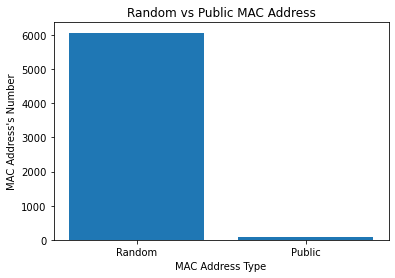

In [10]:
# plotRandomPublicMAC(data)
plotRandomPublicMAC(data_20220712)

Existe una clara victoria para las direcciones MAC aleatorias de todas las tramas recogidas por el ESP32.

Esto podría suponer un problema, aunque existen maneras para intentar minimizar todo lo posible el impacto de este efecto. Uno de ellos es el de seccionar en intervalos de tiempo cortos (en este caso de 5 minutos), de manera que aunque cambie de dirección dentro de ese intervalo, la variación en el total de dispositivos captados será mínimo y lo precisa posible.

## Evolución del número de dispositivos

Con la ayuda de un contador de personas instalado la puerta de la biblioteca, se ha realizado una medición de cuantas personas hay dentro. Podemos representar la evolución de este dato para comprobar si tiene una forma similar a la obtenida con los receptores BLE:

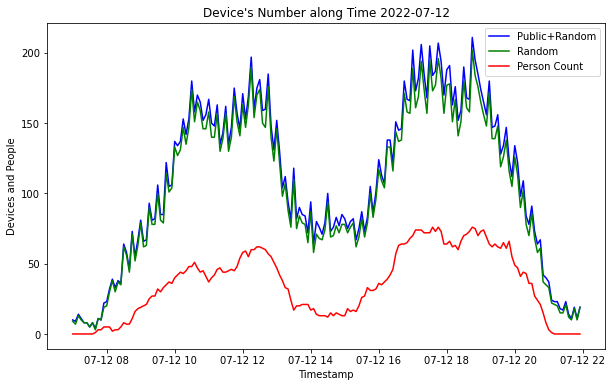

In [11]:
# plotTotalDevices(data, fullPersonCountInterval)
plotTotalDevices(data_20220712, fullPersonCountInterval_20220712)

Se puede apreciar claramente que las curvas poseen un parecido bastante interesante. La diferencia de amplitud entre el número de personas (rojo) y el número de dispositivos (azul y verde) se debe a que normalmente una persona cuenta con más de un dispositivo, por ejemplo, un móvil, portátil, auriculares, etc.

Además, podemos cargar los datos de distintos días para así poder comparar la evolución entre distintos días:

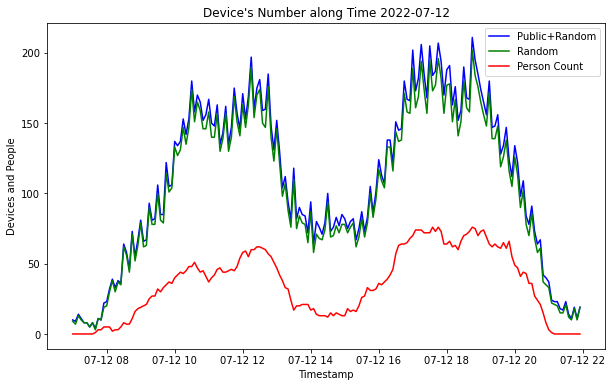

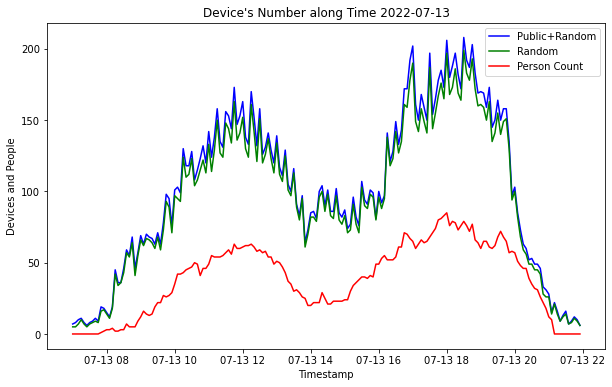

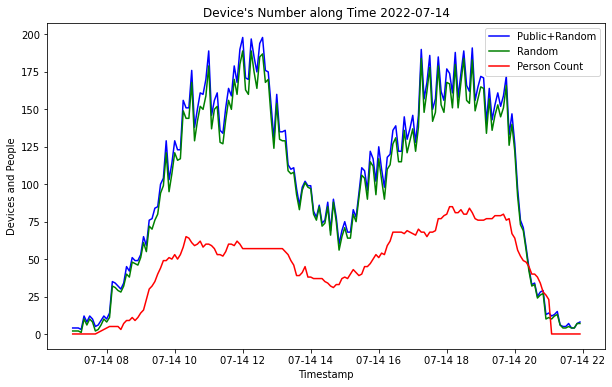

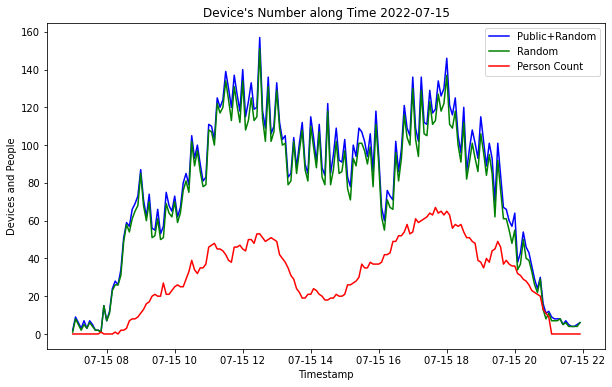

In [12]:
# plotTotalDevices(data, fullPersonCountInterval)
plotTotalDevices(data_20220712, fullPersonCountInterval_20220712)
plotTotalDevices(data_20220713, fullPersonCountInterval_20220713)
plotTotalDevices(data_20220714, fullPersonCountInterval_20220714)
plotTotalDevices(data_20220715, fullPersonCountInterval_20220715)

Como se puede ver, la forma de la gráfica no varía y lo único que varía es la amplitud.

Todas las funciones desarrolladas permiten elegir entre utilizar todo el conjunto de datos o únicamente las direcciones Random, para tener más flexibilidad a la hora de tratar los datos.

Para tener una visión más específica de dónde se concentran los dispositivos, vamos a aprovechar el hecho de tener repartidos los receptores en distintas localizaciones para visualizar la evolución de cada uno de los receptores:

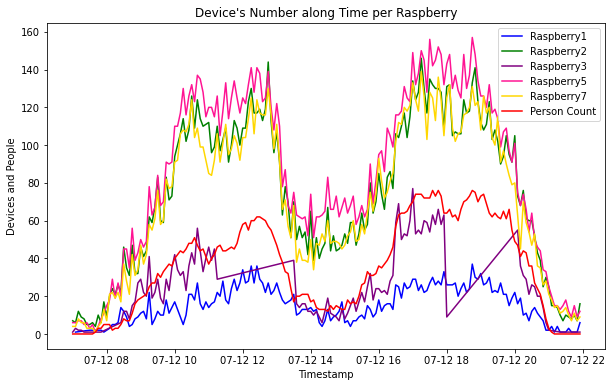

In [13]:
# plotTotalDevicesByRaspberry(data, fullPersonCountInterval, rand=False, initHour=None, endHour=None)
plotTotalDevicesByRaspberry(data_20220712, fullPersonCountInterval_20220712)

Observando el resultado obtenido, vemos que tiene sentido que tanto a tempranas como a altas horas del día (antes de las 08:00 cuando está cerrada y a partir de las 21:00 h cuando la biblioteca cierra) el número de dispositivos capturados decrezca.

Además, los datos tienen dos claros picos de actividad, situados entre las 10:00 h-13:00 h y 16:00 h-19:00 h. Vamos a hacer Zoom a una de las zonas mencionadas:

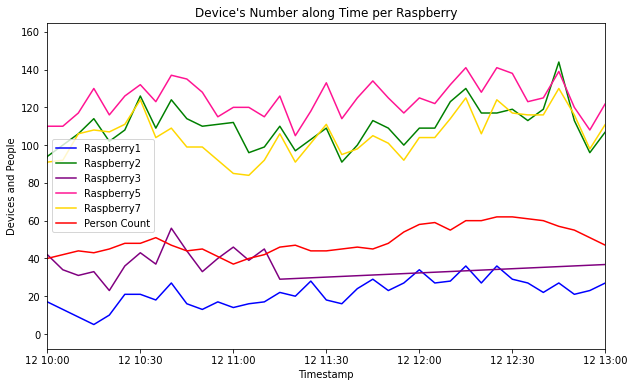

In [14]:
# plotTotalDevicesByRaspberry(data, fullPersonCountInterval, rand=False, initHour=None, endHour=None)
plotTotalDevicesByRaspberry(data_20220712, fullPersonCountInterval_20220712, initHour=10, endHour=13)

## Dispositivos fuera del horario. Cálculo del offset

Los datos muestran que se detectan dispositivos en horas fuera del horario de apertura de la biblioteca, lo que podrían identificarse con personas que pasan por el exterior o dispositivos que ya existen dentro de la biblioteca, lo cuales podríamos eliminar del conjunto. Para ello, vamos a fijarnos en la persistencia de los dispositivos durante un periodo de tiempo fuera del horario. Si un dispositivo se encuentra en todos o casi todos los intervalos de tiempo dentro de ese periodo, podemos asegurar que ese dispositivo está siempre en la zona.

Este estudio se va a hacer entre las 07:00:00 de la mañana y las 07:30:00, además de entre las 21:30:00 y las 22:00:00.
Estas horas son modificables:

In [15]:
# devicesFirstHourDataframe, devicesFirstHour, devicesSecondHourDataframe, devicesSecondHour = devicesOffset(data, rand=False, firstValue='7:00:00', secondValue='21:30:00', interval=30, threshold=70, show=True)
devicesFirstHourDataframe_20220712, devicesFirstHour_20220712, devicesSecondHourDataframe_20220712, devicesSecondHour_20220712 = devicesOffset(data_20220712)

Número de dispositivos entre las 7:00:00 y las 07:30:00 del día 2022-07-12: 3
Número de dispositivos entre las 21:30:00 y las 22:00:00 del día 2022-07-12: 2



Como se puede ver, estos resultados los obtenemos para un martes y usamos un intervalo de media hora, 30 minutos. Podríamos ampliar el experimento usando más días para comprobar si el número de dispositivos es parecido, además de variar el intervalo de muestreo:

In [16]:
# devicesFirstHourDataframe, devicesFirstHour, devicesSecondHourDataframe, devicesSecondHour = devicesOffset(data, rand=False, firstValue='7:00:00', secondValue='21:30:00', interval=30, threshold=70, show=True)
devicesFirstHourDataframe_20220712, devicesFirstHour_20220712, devicesSecondHourDataframe_20220712, devicesSecondHour_20220712 = devicesOffset(data_20220712)
devicesFirstHourDataframe_20220713, devicesFirstHour_20220713, devicesSecondHourDataframe_20220713, devicesSecondHour_20220713 = devicesOffset(data_20220713)
devicesFirstHourDataframe_20220714, devicesFirstHour_20220714, devicesSecondHourDataframe_20220714, devicesSecondHour_20220714 = devicesOffset(data_20220714)
devicesFirstHourDataframe_20220715, devicesFirstHour_20220715, devicesSecondHourDataframe_20220715, devicesSecondHour_20220715 = devicesOffset(data_20220715)

Número de dispositivos entre las 7:00:00 y las 07:30:00 del día 2022-07-12: 3
Número de dispositivos entre las 21:30:00 y las 22:00:00 del día 2022-07-12: 2

Número de dispositivos entre las 7:00:00 y las 07:30:00 del día 2022-07-13: 2
Número de dispositivos entre las 21:30:00 y las 22:00:00 del día 2022-07-13: 2

Número de dispositivos entre las 7:00:00 y las 07:30:00 del día 2022-07-14: 3
Número de dispositivos entre las 21:30:00 y las 22:00:00 del día 2022-07-14: 1

Número de dispositivos entre las 7:00:00 y las 07:30:00 del día 2022-07-15: 2
Número de dispositivos entre las 21:30:00 y las 22:00:00 del día 2022-07-15: 1



Basándonos en estos cuatro días, vemos que los resultados son bastante parecidos, con una media de dos dispositivos por la mañana y uno por la noche. Aun así, para que este experimento sea más confiable, deber probarse en un día donde la biblioteca permanezca cerrada por completo, por ejemplo, un sábado o domingo. Si los resultado son similares en un día como este, podemos confirmar que esos dispositivos se encuentran siempre en el entorno y no corresponden a personas.

In [17]:
# devicesFirstHourDataframe, devicesFirstHour, devicesSecondHourDataframe, devicesSecondHour = devicesOffset(data, rand=False, firstValue='7:00:00', secondValue='21:30:00', interval=30, threshold=70, show=True)
data_20220716 = pd.read_csv('docs/ble-filter-clean-P_2022-07-16.csv', sep=';')
data_20220716["Timestamp int."] = pd.to_datetime(data_20220716["Timestamp int."])
data_20220716 = data_20220716.rename(columns={"Timestamp int.": "Timestamp"})
devicesFirstHourDataframe_20220716, devicesFirstHour_20220716, devicesSecondHourDataframe_20220716, devicesSecondHour_20220716 = devicesOffset(data_20220716)

Número de dispositivos entre las 7:00:00 y las 07:30:00 del día 2022-07-16: 2
Número de dispositivos entre las 21:30:00 y las 22:00:00 del día 2022-07-16: 1



Efectivamente, obtenemos resultados similares que para los días de la semana, lo cual confirma que existen dispositivos que se encuentran siempre en la biblioteca funcionando fuera del horario, lo que nos permite eliminarlos.

## Cálculo del error y ratio dispositivos/personas

A priori la única manera que tenemos de comparar días entre si es representándolos gráficamente y observandolos.
Para solucionar esto, podemos calcular el error que existe entre el número de dispositivos captados por los receptores y el número de personas contabilizadas por el sensor en la entrada. Esto no dará un valor con el que podremos medir y comparar entre distintos días.


In [18]:
# error, quadraticError, variance = errorCalc(data, fullPersonCountInterval, rand=False, startHour='8:00:00', finalHour='21:00:00', show=True)
error_20220712, quadraticError_20220712, variance_20220712 = errorCalc(data_20220712, fullPersonCountInterval_20220712)

El error medio del día es: 82.185
El error cuadrático medio del día es: 7570.006
La varianza del error del día es: 816.0


Una vez que ya podemos tener estas tres medidas para cualquier día, es hora de comparar distintos días y ver un resumen para cada uno de ellos.
Para ello, ejecutamos una primera función que lee todos los archivos en un directorio y los prepara para posteriormente, hacer los calculos recogiendolos en una tabla para que pueda verse más sencillamente.

In [19]:
# dataArray, fullPersonCountArray = readDataFromDirectory(dataPath, fullPersonCountPath)
dataArray, fullPersonCountIntervalArray = readDataFromDirectory('docs/data/', 'docs/personcount/')
# errorMetrics = errorCalcList(dataArray, fullPersonCountIntervalArray, rand=False, startHour='8:00:00', finalHour='21:00:00', show=False)
errorMetricsList = errorCalcList(dataArray, fullPersonCountIntervalArray)

          Date Start Hour  End Hour    Error Quadratic Error Variance
0   2022-06-29    8:00:00  21:00:00   27.497        4824.389   4068.0
1   2022-06-30    8:00:00  21:00:00    70.21        5744.669    815.0
2   2022-07-01    8:00:00  21:00:00   34.987        2275.025   1051.0
3   2022-07-04    8:00:00  21:00:00   91.541        9487.452   1108.0
4   2022-07-05    8:00:00  21:00:00  165.631       30082.739   2649.0
5   2022-07-06    8:00:00  21:00:00   151.28       26195.624   3310.0
6   2022-07-07    8:00:00  21:00:00   94.357        10482.51   1579.0
7   2022-07-11    8:00:00  21:00:00    87.49        8768.841   1114.0
8   2022-07-12    8:00:00  21:00:00   82.185        7570.006    816.0
9   2022-07-13    8:00:00  21:00:00   70.726        5819.822    818.0
10  2022-07-14    8:00:00  21:00:00   67.777        5746.299   1153.0
11  2022-07-15    8:00:00  21:00:00   54.726        3515.987    521.0
12  2022-07-19    8:00:00  21:00:00   68.981        5331.389    573.0


El error lo calculamos como la diferencia entre el número de dispositivos dado por los receptores y el número de personas contadas por el sensor de la entrada en cada intervalo de tiempo. Esto puede indicar que a mayor error, los usuarios deben ir provistos de más dispositivos cada uno o se está produciendo un error a la hora de contabilizar dispositivos, añadiendo dispositivos temporales o no están en el interior de la biblioteca.

Para apoyar esta métrica, puede ser interesante obtener la relación entre el número de dispositivos y el número de personas, para así poder obtener una estimación de cuantos dispositivos porta cada usuario.

In [20]:
# ratioDataframe, ratio = deviceRatio(data, fullPersonCountInterval, rand=False, startHour='8:00:00', finalHour='21:00:00', show=True, offset=False, firstValue='7:00:00', secondValue='21:30:00', interval=30, threshold=70)
ratioDataframe_20220712, ratio_20220712 = deviceRatio(data_20220712, fullPersonCountInterval_20220712)

El ratio medio es: 3.72


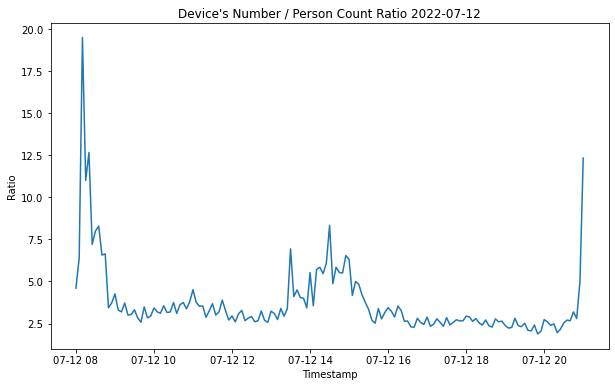

In [21]:
# plotDeviceRatio(data, fullPersonCountInterval, rand=False, startHour='8:00:00', finalHour='21:00:00', show=False, offset=False, firstValue='7:00:00', secondValue='21:30:00', interval=30, threshold=70)
plotDeviceRatio(data_20220712, fullPersonCountInterval_20220712)

Como se puede ver, hay un gran pico a primera hora de la mañana y se estabiliza a lo largo del día. Vamos a representar diferentes días para comparar esta evolución:

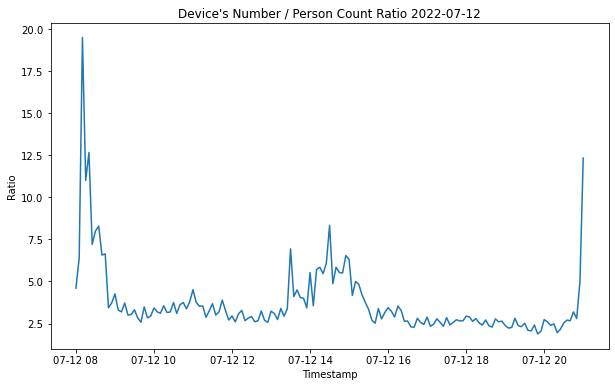

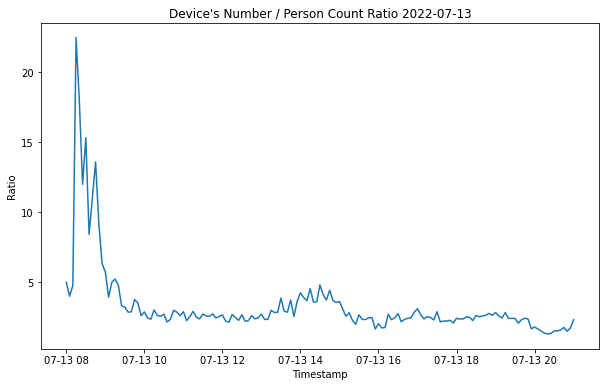

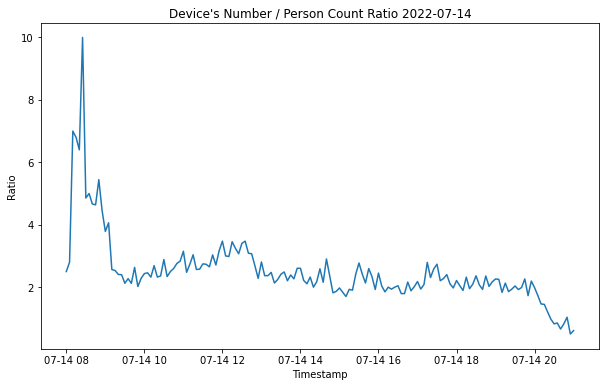

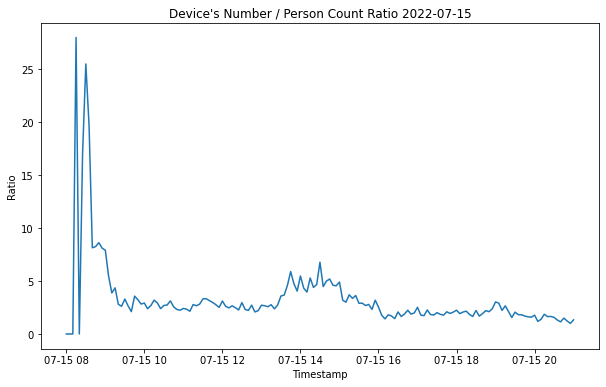

In [22]:
# plotDeviceRatio(data, fullPersonCountInterval, rand=False, startHour='8:00:00', finalHour='21:00:00', show=False, offset=False, firstValue='7:00:00', secondValue='21:30:00', interval=30, threshold=70)
plotDeviceRatio(data_20220712, fullPersonCountInterval_20220712)
plotDeviceRatio(data_20220713, fullPersonCountInterval_20220713)
plotDeviceRatio(data_20220714, fullPersonCountInterval_20220714)
plotDeviceRatio(data_20220715, fullPersonCountInterval_20220715)

Vemos que tienen sus diferencias, pero aproximadamente tienen bastantes semejanzas.
El primer pico es debido a que los receptores estám capurando algún mensaje dado por algún dispositivo temporal o que simplemente está de paso, sin embargo nadie ha entrado a la biblioteca, por lo que el ratio aumenta.

Anteriormente se ha planteado la opción de que existan dispositivos ya establecidos en la biblioteca fuera del horario de apertura que estén generando continuamente mensajes, los cuales podríamos suprimir. Vamos a representar ahora el ratio teniendo esto en cuenta:

El ratio medio es: 3.63


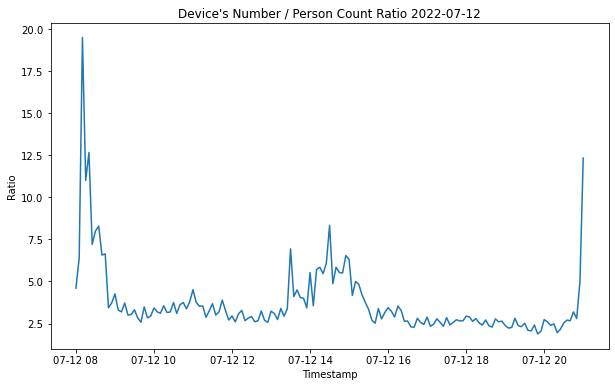

In [23]:
# ratioDataframe, ratio = deviceRatio(data, fullPersonCountInterval, rand=False, startHour='8:00:00', finalHour='21:00:00', show=True, offset=False, firstValue='7:00:00', secondValue='21:30:00', interval=30, threshold=70)
ratioDataframe_20220712, ratio_20220712 = deviceRatio(data_20220712, fullPersonCountInterval_20220712, offset=True)
# plotDeviceRatio(data, fullPersonCountInterval, rand=False, startHour='8:00:00', finalHour='21:00:00', show=False, offset=False, firstValue='7:00:00', secondValue='21:30:00', interval=30, threshold=70)
plotDeviceRatio(data_20220712, fullPersonCountInterval_20220712, offset=True)

Como también se ha visto antes, son muy pocos los dispositivos que asignamos a esta categoría, por lo que la diferencia es minúscula.
Por último, vemos que las zonas donde más personas hay, el ratio tiende a ser inferior que las franjas de tiempo donde el número de personas es menor. Esto lo podemos representar con una nube de puntos para visualizar el ratio en funcion del número de personas.

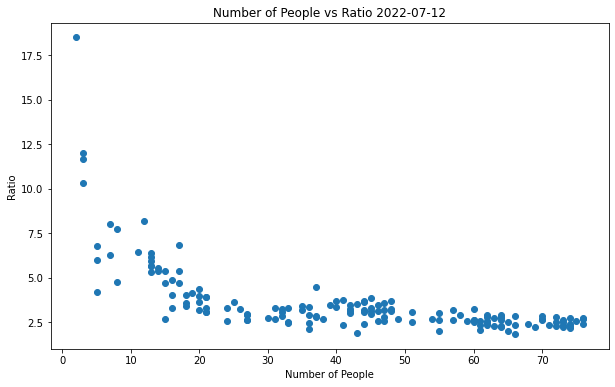

In [24]:
# plotPersonCountRatio(fullPersonCountInterval, ratioDataframe)
plotPersonCountRatio(fullPersonCountInterval_20220712, ratioDataframe_20220712)

## Comparativa días de estudio

Disponemos de 15 días en los que se han generado datos tanto de paquetes BLE como del sensor colocado a la entrada de la biblioteca. Sin embargo, algunos días algun receptor ha fallado y los datos están incompletos, por lo que no son del todo fiables.
Para intentar comparar todos los días, se van a calcular el error medio, ratio medio y offset medio.


In [25]:
# tableMetricList(dataArray, fullPersonCountIntervalArray, rand=False, startHour='8:00:00', finalHour='21:00:00', show=False, firstValue='7:00:00', secondValue='21:30:00', interval=30, threshold=70, offset=False, showDetail=False)
tableMetrics = tableMetricList(dataArray, fullPersonCountIntervalArray)

          Date Start Hour  End Hour    Error Ratio Offset
0   2022-06-29    8:00:00  21:00:00   27.497  1.35   10.0
1   2022-06-30    8:00:00  21:00:00    70.21  2.82    1.0
2   2022-07-01    8:00:00  21:00:00   34.987  1.47   24.0
3   2022-07-04    8:00:00  21:00:00   91.541  3.17    0.0
4   2022-07-05    8:00:00  21:00:00  165.631  5.63    2.0
5   2022-07-06    8:00:00  21:00:00   151.28  5.34    2.0
6   2022-07-07    8:00:00  21:00:00   94.357  2.96    0.0
7   2022-07-11    8:00:00  21:00:00    87.49  5.16    2.0
8   2022-07-12    8:00:00  21:00:00   82.185  3.72    2.0
9   2022-07-13    8:00:00  21:00:00   70.726  3.31    2.0
10  2022-07-14    8:00:00  21:00:00   67.777  2.51    2.0
11  2022-07-15    8:00:00  21:00:00   54.726   3.3    2.0
12  2022-07-19    8:00:00  21:00:00   68.981  2.72    2.0


Además, sería de gran utilidad representar los datos para cada días, de distintas maneras para tener tambien una comparativa visual. Estas gráficas serán:
- Estimación global / Nº real personas vs. Hora intervalo
- Ratio intervalo vs. Hora intervalo
- Nube puntos ratio sobreestimación vs Nº personas

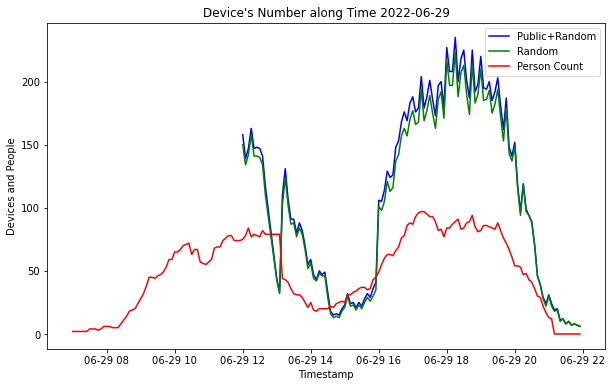

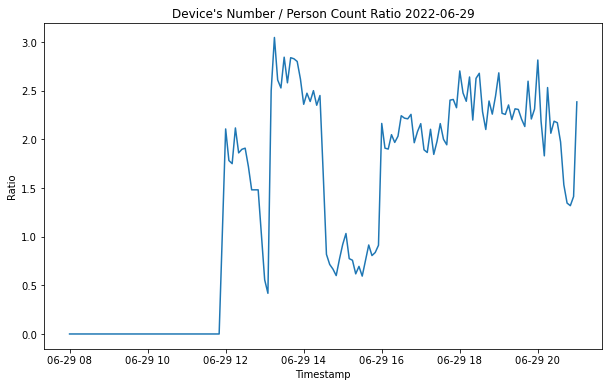

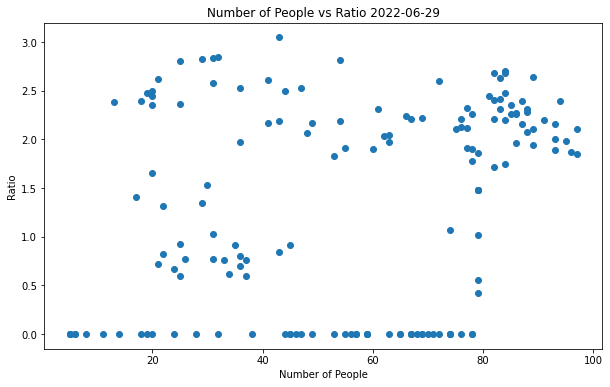

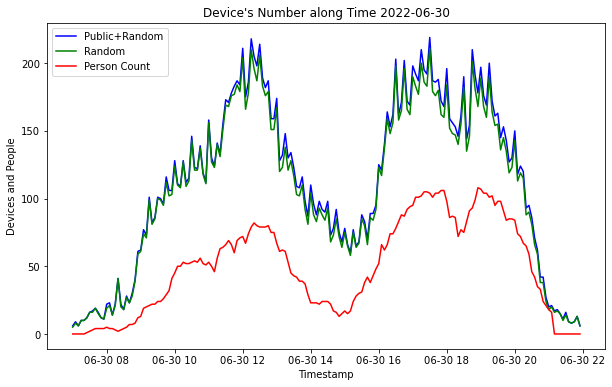

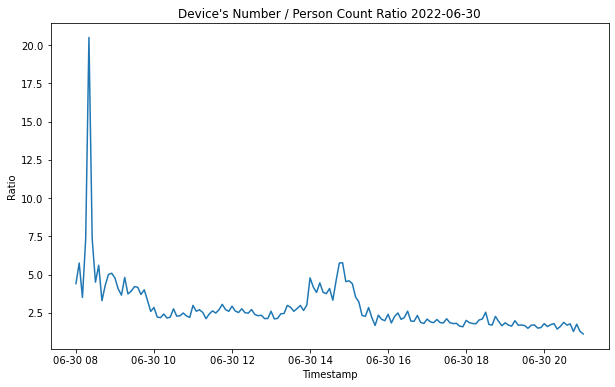

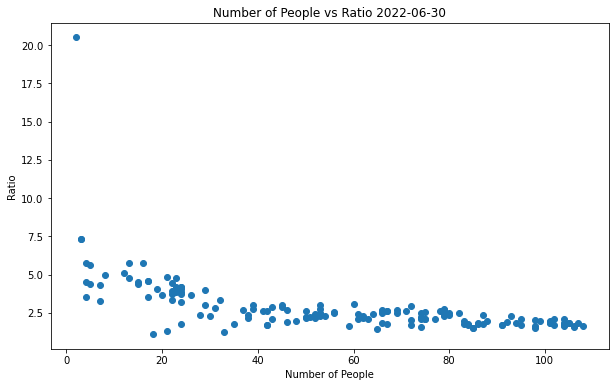

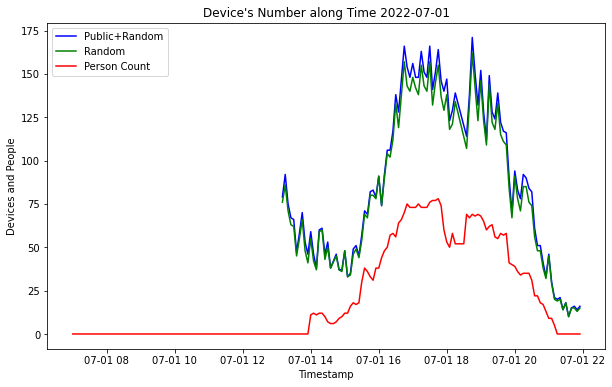

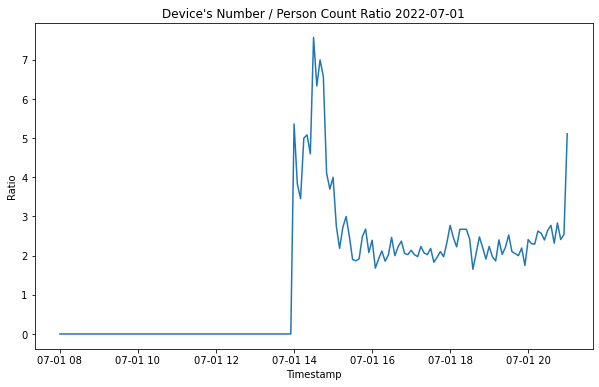

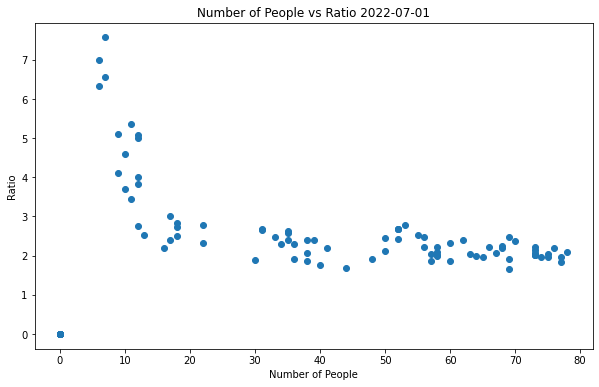

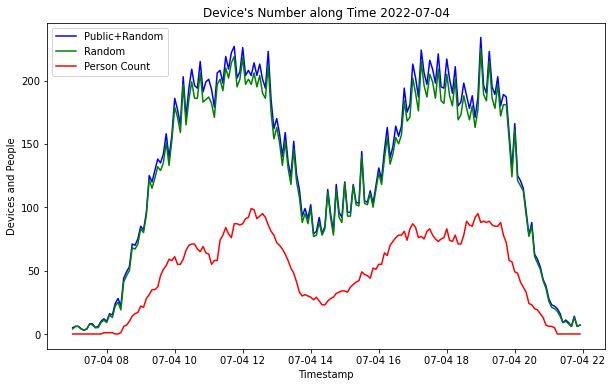

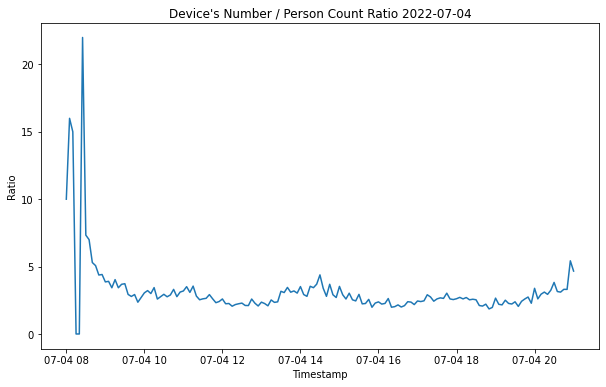

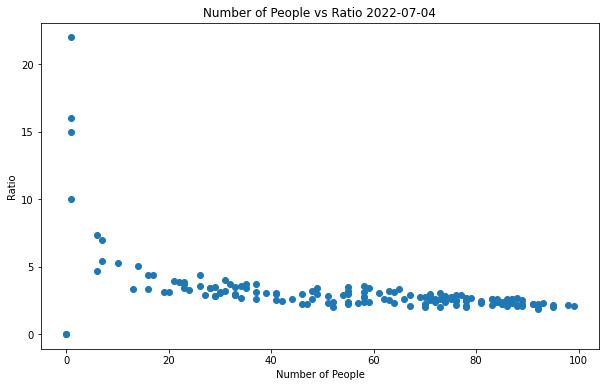

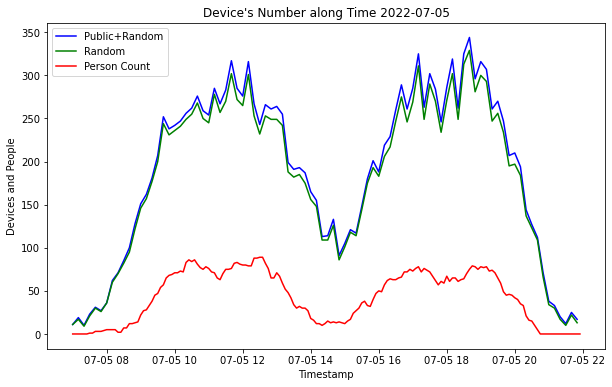

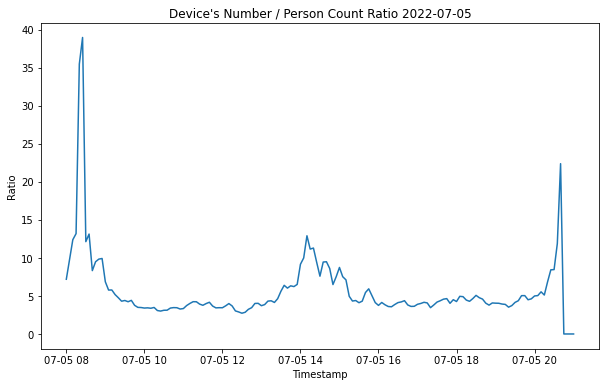

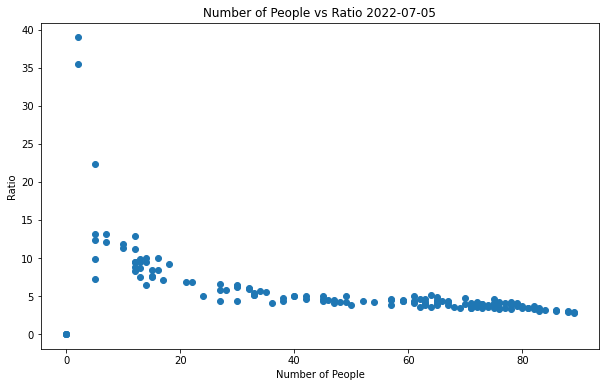

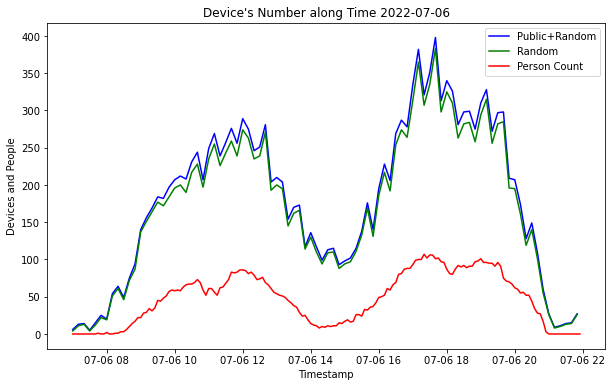

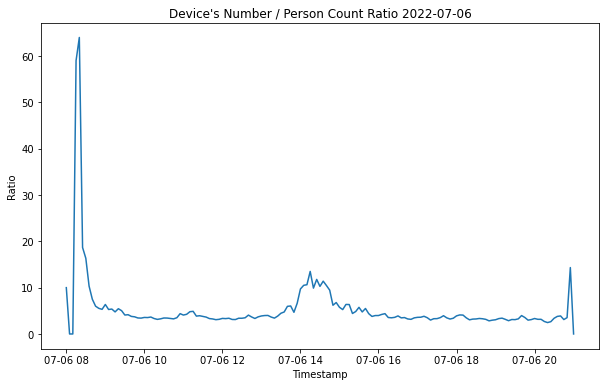

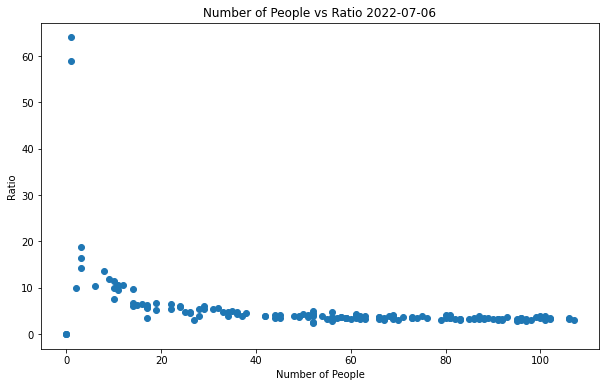

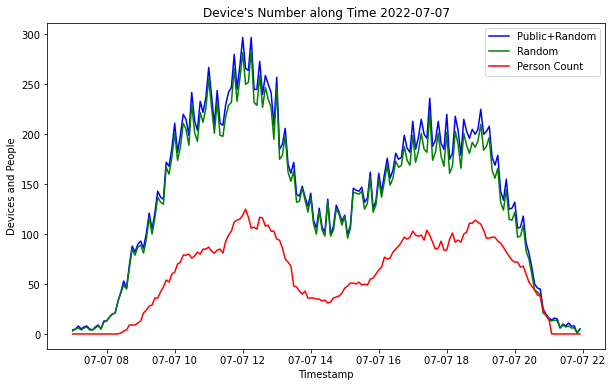

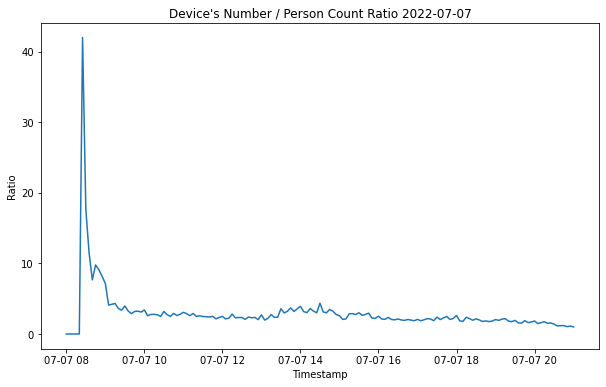

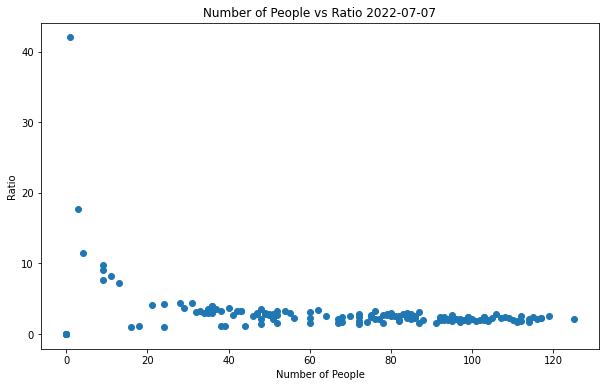

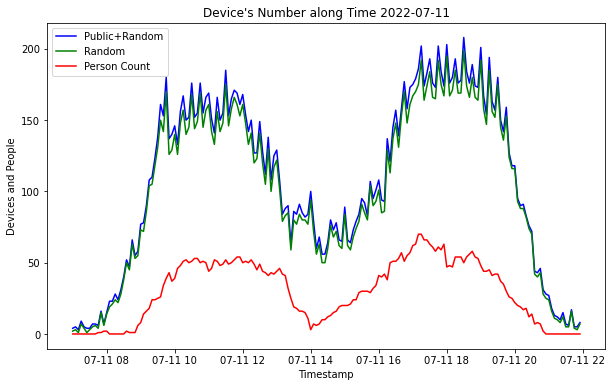

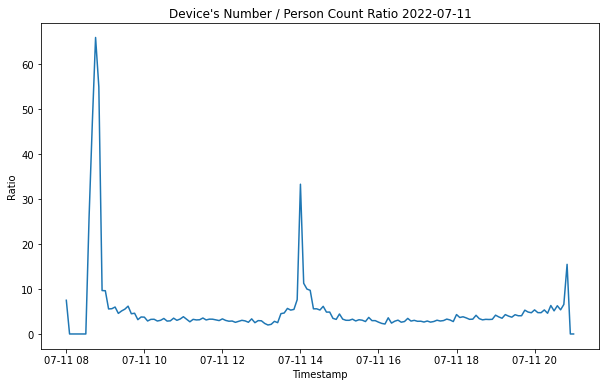

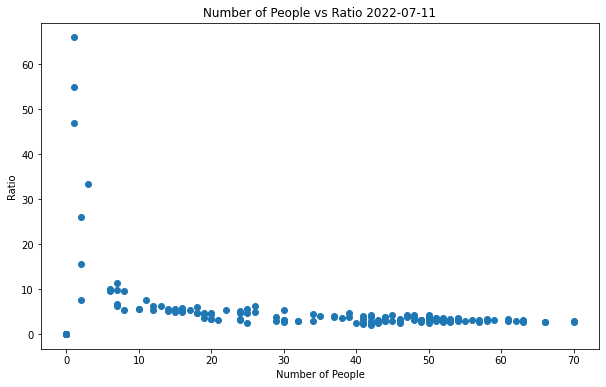

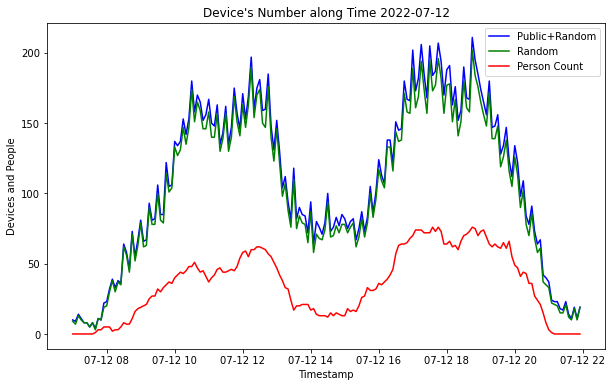

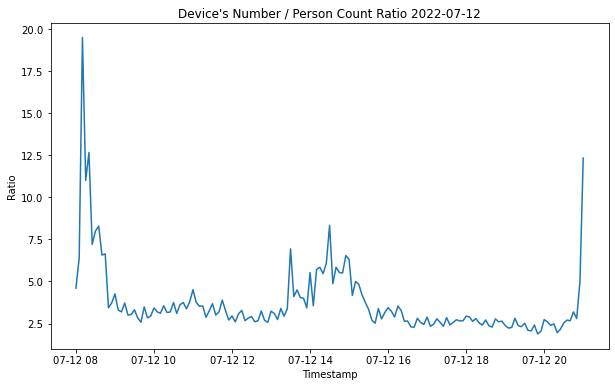

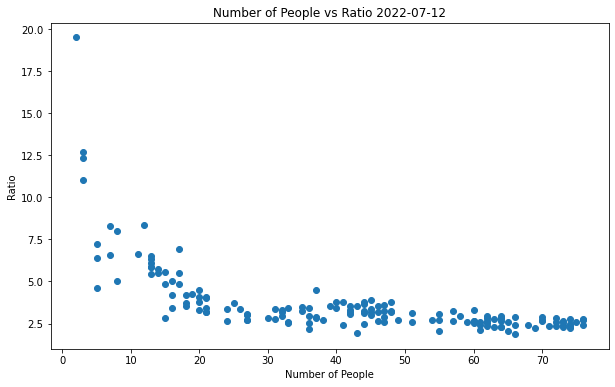

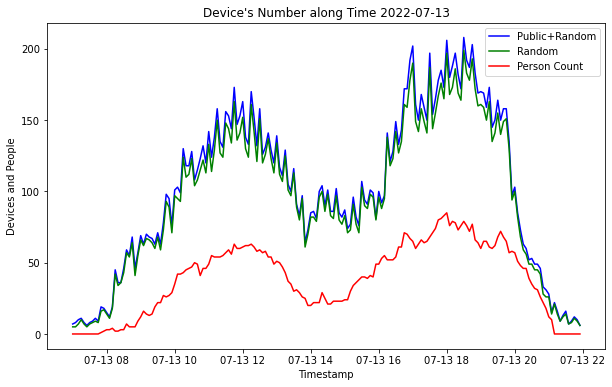

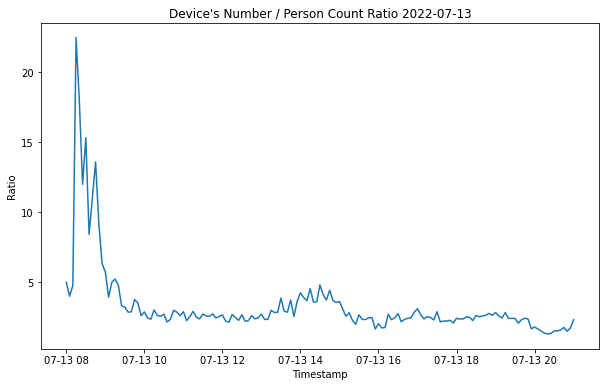

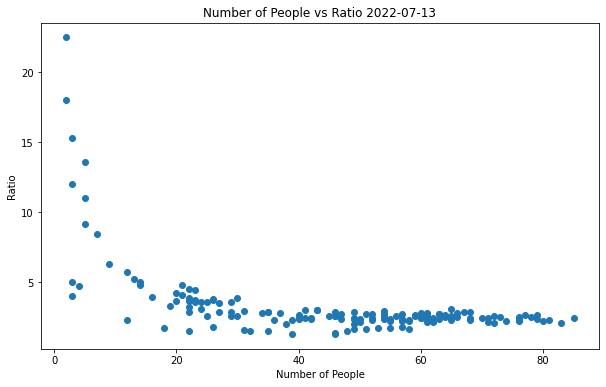

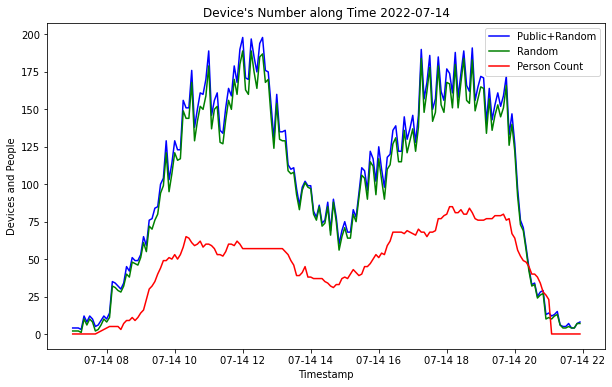

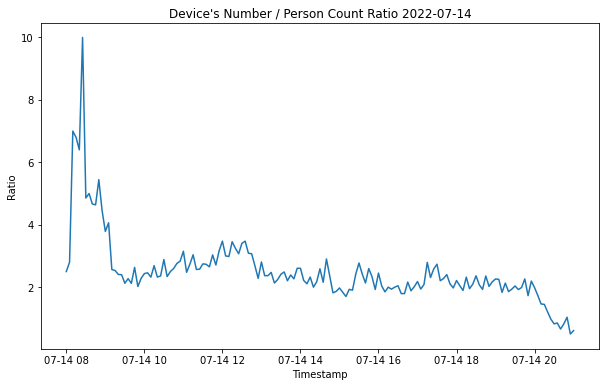

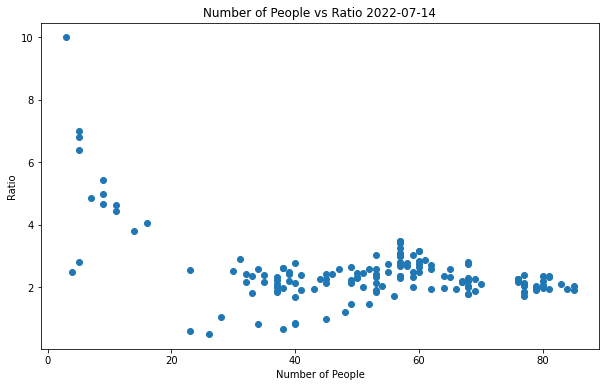

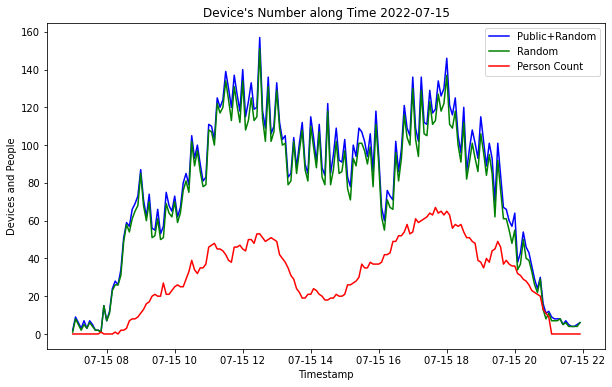

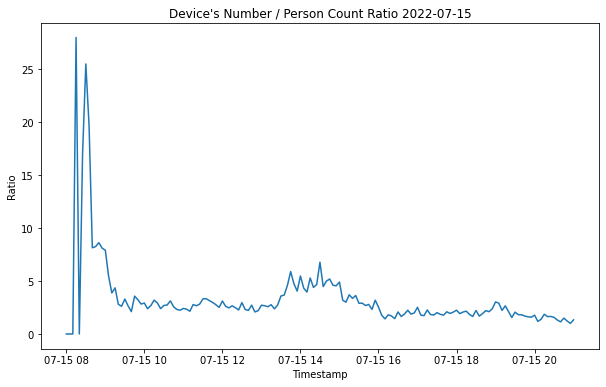

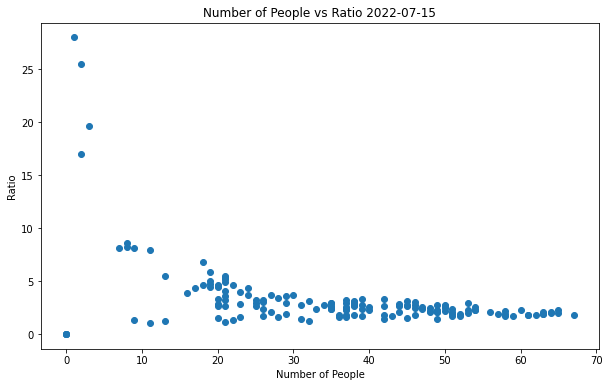

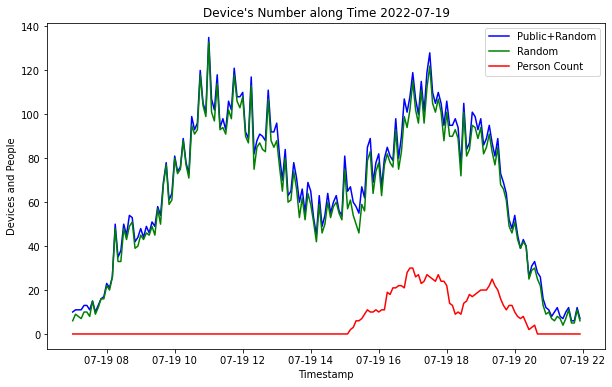

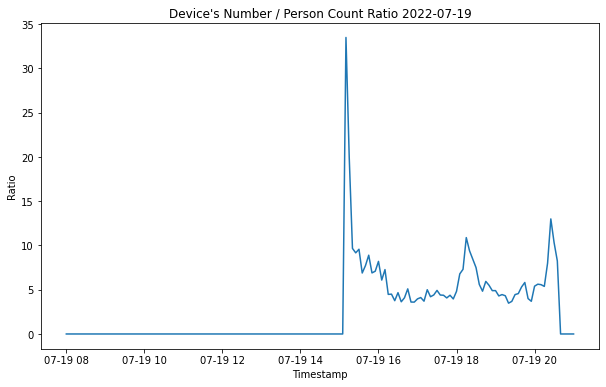

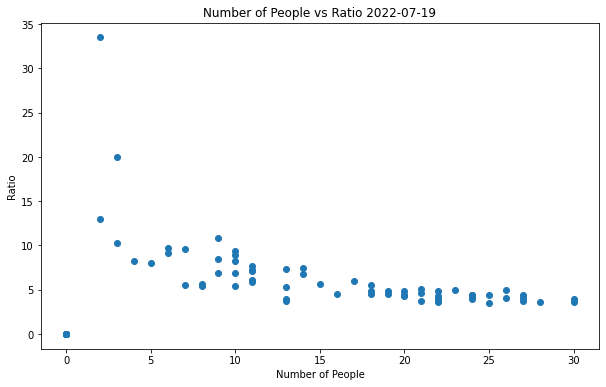

In [26]:
# plotSummaryDay(dataArray, fullPersonCountIntervalArray, rand=False, startHour='8:00:00', finalHour='21:00:00', show=False, offset=False, firstValue='7:00:00', secondValue='21:30:00', interval=30, threshold=70, showDetail=False)
plotSummaryDay(dataArray, fullPersonCountIntervalArray)

## Estudio de la potencia y número de mensajes

La potencia con la que se captan los mensajes también nos puede aportar mucha información, puede indicar que un dispositivo se está alejando o acercando a un receptor, o tal vez que se encuentra fuera del lugar de estudio.

Por ello también sería interesante visualizar tanto el número de paquetes recibidos por un dispositivo como la potencia con la que llegan, ya que si se encuentran pocos paquetes con poca potencia de un dispositivo, seguramente se traten de dispositivos externos o poco relevantes que se pueden eliminar para el cálculo, incorporarlos podría generar ruido en el procesado posterior.

Comenzaremos mostrando la evolución en el número de dispositivos contenidos en unos rangos de potencia variables con respecto a la mínima potencia captada:

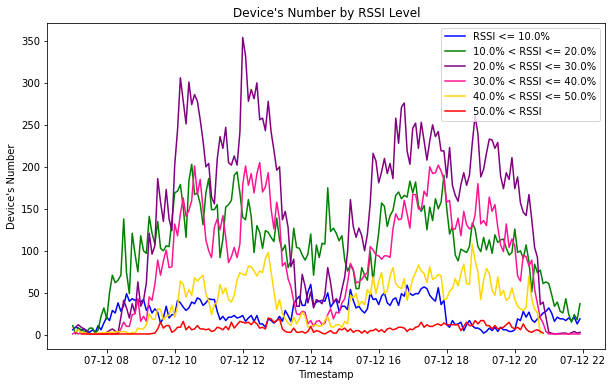

In [27]:
# plotTotalDevicesByRSSI(data, rand=False, initValue=10, endValue=50)
plotTotalDevicesByRSSI(data_20220712)

Lo más relevante de esta gráfica es que confirma que existen muy pocos dispositivos con alta potencia en recepción (rojo) y los dispositivos con muy poca potencia en recepción tampoco sno mucho mayores a los anteriores mencionados (azul). La mayoría de dispositivos se agrupa en unos niveles de señales medios.

Si nos centramos en el caso particular de cada receptor, podemos conseguir los siguientes resultados:

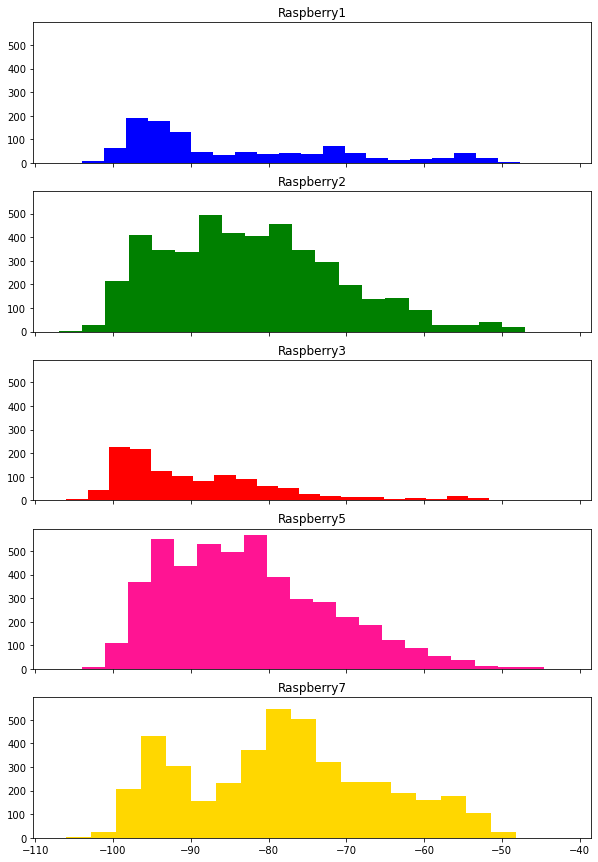

In [28]:
# histTotalDevicesByRSSIAndRaspberry(data, rand=False, bins=20)
histTotalDevicesByRSSIAndRaspberry(data_20220712)

Para continuar con lo anterior, necesitamos representar el número de mensajes recibidos por cada dispositivo. Sin embargo, esto puede ser costoso, ya que en cada conjunto de datos puede haber muchos dispositivos (miles) lo cual hace imposible su representación. Una posible solución es representar el número de dispositivos que han enviado un cierto número de mensajes, de manera similar al apartado anterior:

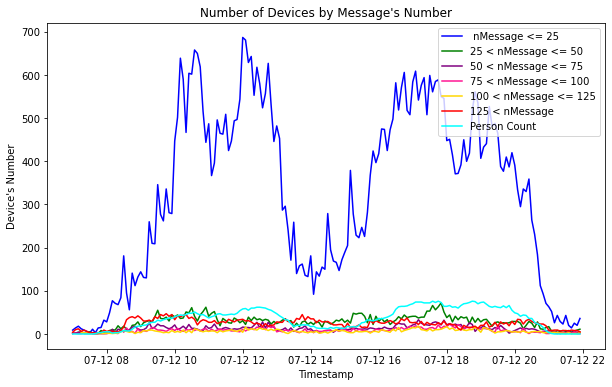

In [29]:
# plotTotalDevicesByMessage(data, fullPersonCountInterval, rand=False, initValue=25, endValue=125, name=None)
plotTotalDevicesByMessage(data_20220712, fullPersonCountInterval_20220712)

Resulta curioso que aparezcan tantos dispositivos con un número de mensajes, sobre todo cuando eso indicaría un número de dispositivos mucho mayor al que habiamos obtenido al principio de este notebook. Esto es debido a que cada vez que un dispositivo es registrado por una Raspberry, cuenta como un dispositivo distinto para este experimento, de manera que si en un intervalo de tiempo un dispositivo ha sido captado por los cinco receptores desplegados, la función tomará cinco veces el valor de ese dispositivo en lugar de solo uno.

En principio, existen muchos dispositivos con muy pocos mensajes, lo que hace que el resto de curvas no se lean correctamente. Vamos a reducir la escala para poder apreciarlo mejor:

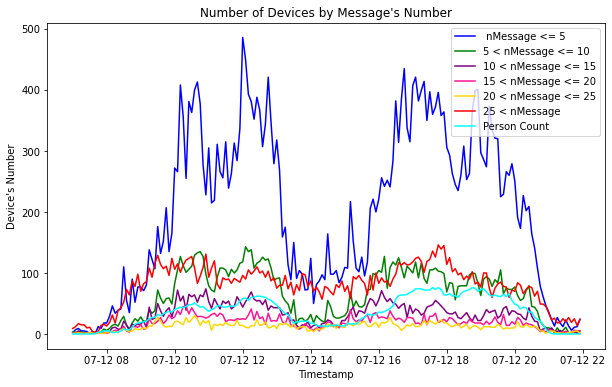

In [30]:
# plotTotalDevicesByMessage(data, fullPersonCountInterval, rand=False, initValue=25, endValue=125, name=None)
plotTotalDevicesByMessage(data_20220712, fullPersonCountInterval_20220712, initValue=5, endValue=25)

Con esta nueva vista, podemos asegurar que existen muchos dispositivos que envían muy pocos mensajes dentro del mismo intervalo de tiempo. Esto se debe a lo descrito anteriormente, se registran los dispositivos más veces de las que debería. Sin embargo, este experimento no es tan irrelevante como pueda parecer.
Gracias a esta vista, podemos concluir que hay dispositivos que se mueven mucho por el entorno, por ello no generan una gran cantidad de mensajes en ningún receptor porque no le da tiempo a ello.

Para poder estudiarlo más detalladamente, lo correcto sería filtrarlo por Raspberry para tener una vista más clara de la evolución.

## Estudio del número de mensajes por Raspberry

Un dispositivo solo es registrado una vez por intervalo de tiempo en un receptor, de este modo podemos completar el estudio previo si lo individualizamos para cada receptor.

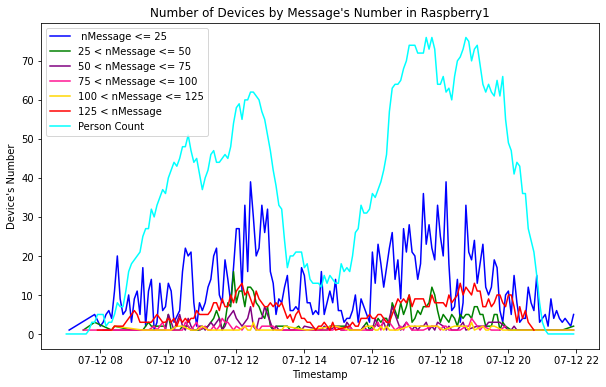

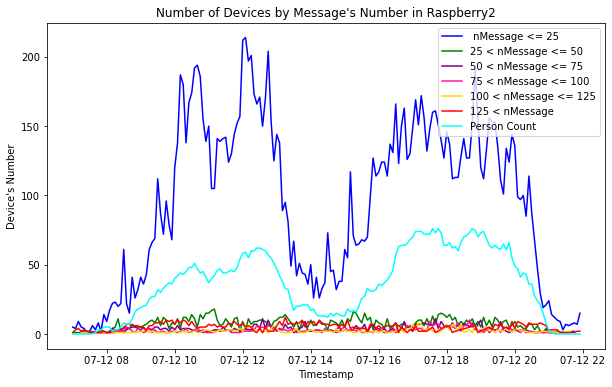

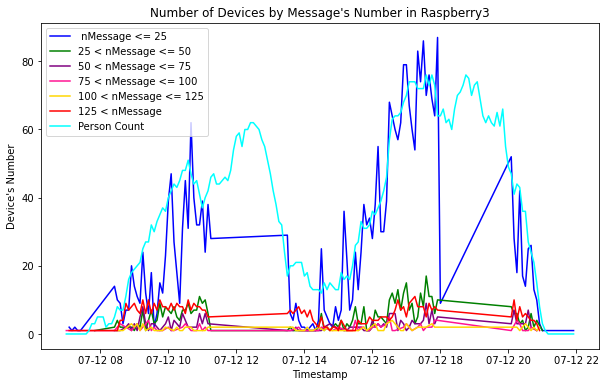

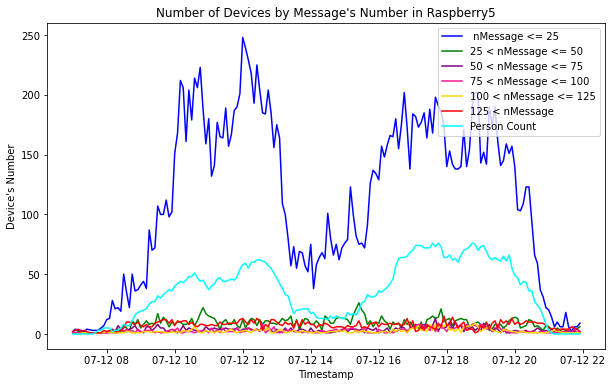

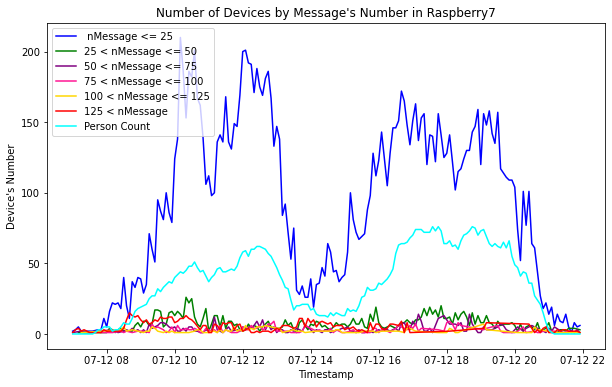

In [31]:
# plotTotalDevicesByMessageByRaspberry(data, fullPersonCountInterval, rand=False, initValue=25, endValue=125)
plotTotalDevicesByMessageByRaspberry(data_20220712, fullPersonCountInterval_20220712)

Reduzcamos la escala para poder ver más en detalle la evolución de los dispositivos:

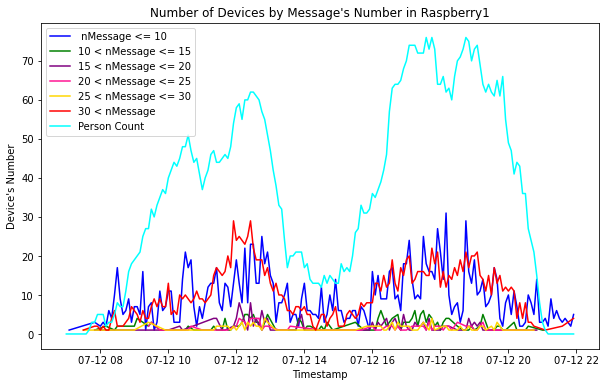

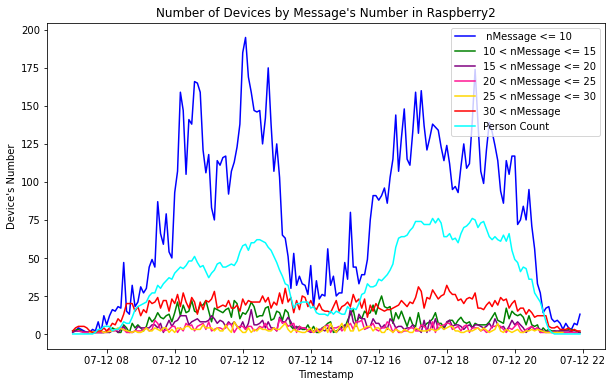

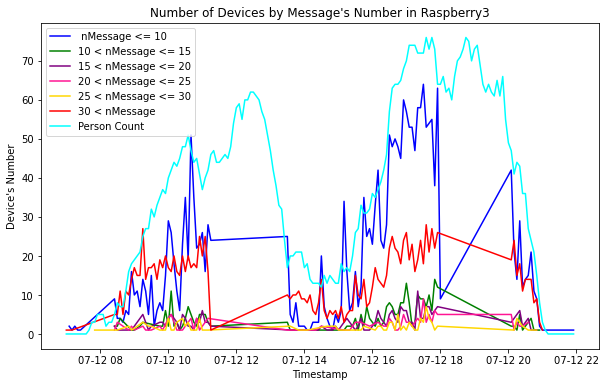

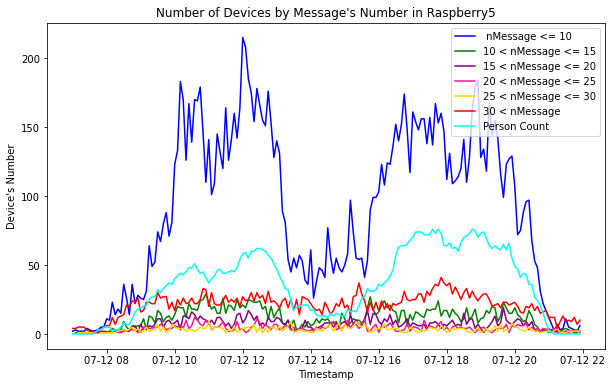

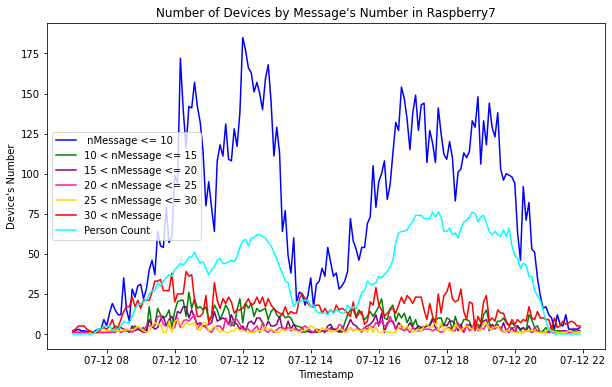

In [40]:
# plotTotalDevicesByMessageByRaspberry(data, fullPersonCountInterval, rand=False, initValue=25, endValue=125)
plotTotalDevicesByMessageByRaspberry(data_20220712, fullPersonCountInterval_20220712, initValue=10, endValue=30)

## Estudio de la sala Jose Villena

A partir de ahora, nos centraremos en los receptores desplegados en la principal sala de estudio, es decir, *Raspberry2*, *Raspberry5*, *Raspberry7*. Dado que comparten cobertura y sus evoluciones temporales son parecidas, podemos sacar algunas conclusiones a partir de los datos que nos aportan.

Por ejemplo, el número de direcciones MAC que encuentra cada receptor, que tanto por ciento de paquetes están por debajo de un umbral de potencia, saber si un dispositivo se ha registrado a la vez en más de un receptor o el tanto por ciento de dispositivos que ya estaban registrados durante el intervalo anterior.

In [33]:
# getMetricsRoom(data, rand=False, RSSIThreshold=-99)
getMetricsRoom(data_20220712)

Número dispositivos captados por la Raspberry2: 99
Número dispositivos captados por la Raspberry5: 96
Número dispositivos captados por la Raspberry7: 101

Número de mensajes captados por la Raspberry2: 459519
Número de mensajes captados por la Raspberry5: 655852
Número de mensajes captados por la Raspberry7: 441071

Tanto por ciento de mensajes por debajo de -99 dB en Raspberry2: 0.2337 %
Tanto por ciento de mensajes por debajo de -99 dB en Raspberry5: 0.0535 %
Tanto por ciento de mensajes por debajo de -99 dB en Raspberry7: 0.0497 %

Tanto por ciento de dispositivos con mensajes por debajo de -99 dB en Raspberry2: 1.4091 %
Tanto por ciento de dispositivos con mensajes por debajo de -99 dB en Raspberry5: 0.6678 %
Tanto por ciento de dispositivos con mensajes por debajo de -99 dB en Raspberry7: 0.5118 %



Como se ha comentado anteriormente, un aspecto que nos puede dar confianza es que un mismo dispositivo sea detectado por más de un receptor en el mismo intervalo de tiempo, para ello recorreremos el datasheet dividido en intervalos de tiempo, comprobando por cuantos y cuáles receptores ha sido capturado ese mensaje.

Los receptores están distribuidos de tal manera que en la sala de estudio, dos de ellos están situados cerca de la pared (Raspberry2 y Raspberry7). Al otro lado de la pared hay un paseo por donde las personas pueden andar. Para intentar filtrar los dispositivos que se encuentran dentro de la biblioteca, podemos discriminarlos de tal manera que deban ser detectados por al menos dos receptores y que estos receptores no sean los que se encuentran instalados en la pared:

             Timestamp                MAC        Raspberry Total
0  2022-07-12 07:00:00  14:1b:f4:3c:f3:b5      Raspberry_5     1
1  2022-07-12 07:00:00  45:63:10:5b:19:8d      Raspberry_2     1
2  2022-07-12 07:00:00  66:68:ef:e1:40:19      Raspberry_2     1
3  2022-07-12 07:00:00  6b:47:3e:09:e4:ec  Raspberry_2_5_7     3
4  2022-07-12 07:00:00  6c:81:e5:45:1c:92  Raspberry_2_5_7     3
5  2022-07-12 07:00:00  7f:1c:1a:a0:6e:66      Raspberry_5     1
6  2022-07-12 07:00:00  c2:ce:06:f1:94:c4      Raspberry_2     1
7  2022-07-12 07:00:00  c6:d1:f4:e8:fa:1a  Raspberry_2_5_7     3
8  2022-07-12 07:00:00  e1:b1:0f:14:75:7d  Raspberry_2_5_7     3
9  2022-07-12 07:05:00  66:68:ef:e1:40:19      Raspberry_2     1

             Timestamp                MAC        Raspberry
0  2022-07-12 07:00:00  6b:47:3e:09:e4:ec  Raspberry_2_5_7
1  2022-07-12 07:00:00  6c:81:e5:45:1c:92  Raspberry_2_5_7
2  2022-07-12 07:00:00  c6:d1:f4:e8:fa:1a  Raspberry_2_5_7
3  2022-07-12 07:00:00  e1:b1:0f:14:75:7d  Raspb

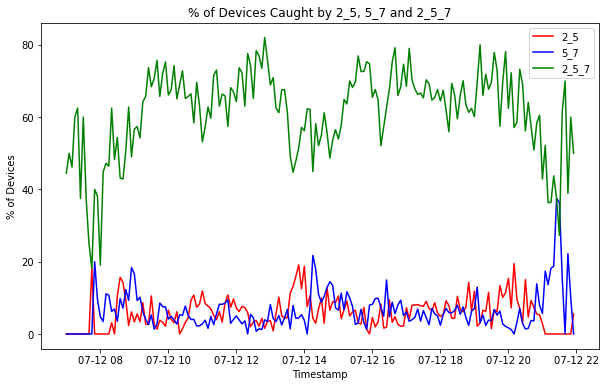

In [34]:
# devicesSummary, devicesOverlap, devicesOverlapRate = devicesOverlapRoom(data, time, rand=False)
devicesSummary_20220712, devicesOverlap_20220712, devicesOverlapRate_20220712 = devicesOverlapRoom(data_20220712, timeSeries_20220712)
# plotDevicesOverlapRoom(deviceOverlapRate)
plotDevicesOverlapRoom(devicesOverlapRate_20220712)

Al igual que es importante saber si un dispositivo se ha registrado en un mismo receptor en el mismo instante de tiempo, es interesante saber si ese dispositivo estaba previamente registrado, es decir, la continuidad del dispositivo en un receptor a lo largo de los instantes de tiempo, lo que indica que no se ha movido del lugar dándonos más confianza en el dato.

             Timestamp    Rate
0  2022-07-12 07:00:00       0
1  2022-07-12 07:05:00    62.5
2  2022-07-12 07:10:00  53.846
3  2022-07-12 07:15:00    60.0
4  2022-07-12 07:20:00    87.5
5  2022-07-12 07:25:00    87.5
6  2022-07-12 07:30:00    60.0
7  2022-07-12 07:35:00    50.0
8  2022-07-12 07:40:00    75.0
9  2022-07-12 07:45:00  27.273

             Timestamp                MAC isIn
0  2022-07-12 07:00:00  14:1b:f4:3c:f3:b5    N
1  2022-07-12 07:00:00  45:63:10:5b:19:8d    N
2  2022-07-12 07:00:00  66:68:ef:e1:40:19    N
3  2022-07-12 07:00:00  6b:47:3e:09:e4:ec    N
4  2022-07-12 07:00:00  6c:81:e5:45:1c:92    N
5  2022-07-12 07:00:00  7f:1c:1a:a0:6e:66    N
6  2022-07-12 07:00:00  c2:ce:06:f1:94:c4    N
7  2022-07-12 07:00:00  c6:d1:f4:e8:fa:1a    N
8  2022-07-12 07:00:00  e1:b1:0f:14:75:7d    N
9  2022-07-12 07:05:00  66:68:ef:e1:40:19    Y


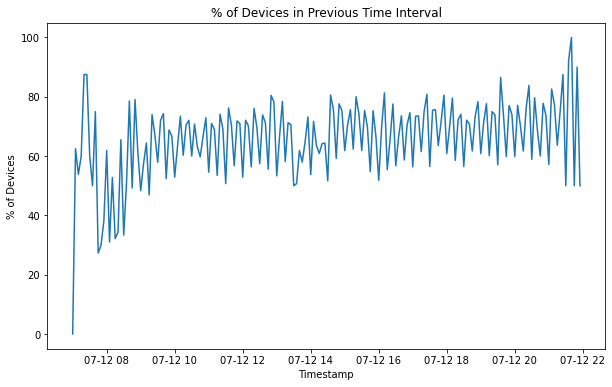

In [35]:
# devicesInPreviousInterval, devicesMACInPreviousInterval =  devicesOverlapRoomDetail(time, deviceSummary)
devicesInPreviousInterval_20220712, devicesMACInPreviousInterval_20220712 = devicesOverlapRoomDetail(timeSeries_20220712, devicesSummary_20220712)
# plotDevicesOverlapRoomDetail(devicesInPreviousInterval)
plotDevicesOverlapRoomDetail(devicesInPreviousInterval_20220712)

Al igual que hemos aplicado el offset en un caso anterior, vamos a aplicarlo para el caso específico de la sala de estudio:

In [36]:
# deviceOverlapOffset = devicesOffsetRoom(deviceOverlap, rand=False, firstValue='7:00:00', secondValue='21:30:00', interval=30, threshold=70, show=True)
deviceOverlapOffset_20220712 = devicesOffsetRoom(devicesOverlap_20220712)

Número de dispositivos entre las 7:00:00 y las 07:30:00 del día 2022-07-12: 2
Número de dispositivos entre las 21:30:00 y las 22:00:00 del día 2022-07-12: 1



Número de dispositivos entre las 7:00:00 y las 07:30:00 del día 2022-07-12: 2
Número de dispositivos entre las 21:30:00 y las 22:00:00 del día 2022-07-12: 1



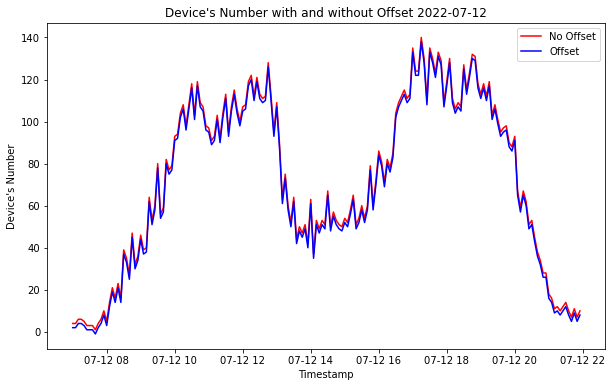

In [37]:
# plotdevicesOffsetRoom(deviceOverlap, rand=False, firstValue='7:00:00', secondValue='21:30:00', interval=30, threshold=70, show=True)
plotDevicesOffsetRoom(devicesOverlap_20220712)

Aprovechando que tenemos el dato del número de personas reales que habia en esta sala para el día 11 y 14 de julio, vamos a sacar los valores de interes como el numero de dispositivos estimados, el error y el ratio:

             Timestamp                MAC        Raspberry Total
0  2022-07-11 07:00:00  28:de:65:43:67:5a      Raspberry_5     1
1  2022-07-11 07:00:00  4c:cd:23:a9:c1:16      Raspberry_5     1
2  2022-07-11 07:00:00  68:72:c3:96:c8:2f      Raspberry_2     1
3  2022-07-11 07:00:00  6f:3c:f5:2b:32:48      Raspberry_2     1
4  2022-07-11 07:05:00  17:73:ae:47:d2:6b    Raspberry_5_7     2
5  2022-07-11 07:05:00  28:de:65:43:67:5a      Raspberry_5     1
6  2022-07-11 07:05:00  45:2d:8d:e5:ce:5b  Raspberry_2_5_7     3
7  2022-07-11 07:05:00  4c:cd:23:a9:c1:16      Raspberry_5     1
8  2022-07-11 07:05:00  68:72:c3:96:c8:2f      Raspberry_2     1
9  2022-07-11 07:10:00  68:72:c3:96:c8:2f      Raspberry_2     1

             Timestamp                MAC        Raspberry
0  2022-07-11 07:05:00  17:73:ae:47:d2:6b    Raspberry_5_7
1  2022-07-11 07:05:00  45:2d:8d:e5:ce:5b  Raspberry_2_5_7
2  2022-07-11 07:15:00  49:a3:5a:40:76:1f  Raspberry_2_5_7
3  2022-07-11 07:20:00  49:a3:5a:40:76:1f  Raspb

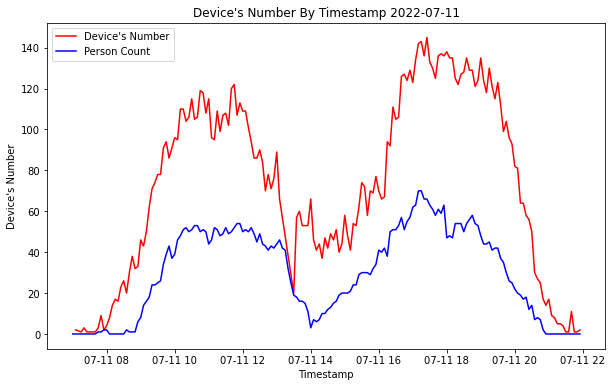

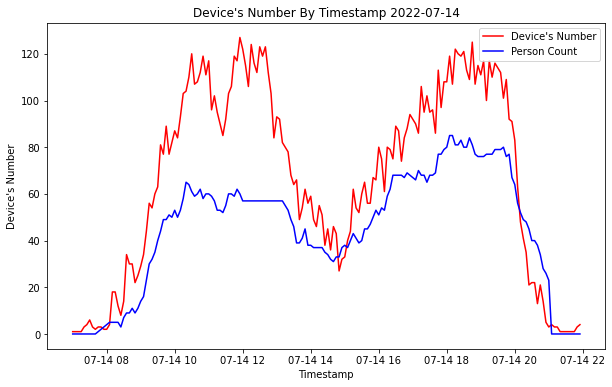

In [38]:
data_20220711 = pd.read_csv('docs/data/ble-filter-clean-P_2022-07-11.csv', sep=';')
personCount_20220711 = pd.read_csv('docs/personcount/PersonCount_2022-07-11_7-22.csv', sep=';')
data_20220711, personCount_20220711 = transformTimestamp(data_20220711, personCount_20220711)
timeSeries_20220711 = generateTimeSeries(data_20220711)
fullPersonCountInterval_20220711 = parsePersonCount(timeSeries_20220711, personCount_20220711)
fullPersonCountInterval_20220714 = parsePersonCount(timeSeries_20220714, personCount_20220714)
_, devicesOverlap_20220711, _ = devicesOverlapRoom(data_20220711, timeSeries_20220711)
_, devicesOverlap_20220714, _ = devicesOverlapRoom(data_20220714, timeSeries_20220714)
devicesOverlap_20220711 = devicesOverlap_20220711.groupby("Timestamp").nunique()
devicesOverlap_20220714 = devicesOverlap_20220714.groupby("Timestamp").nunique()
nDevices_20220711 = devicesOverlap_20220711.loc[devicesOverlap_20220711.index == "2022-07-11 18:35:00"]["MAC"]
nDevices_20220714 = devicesOverlap_20220714.loc[devicesOverlap_20220714.index == "2022-07-14 17:50:00"]["MAC"]
print(nDevices_20220711)
print(nDevices_20220714)

plt.figure(figsize=(10,6))
plt.plot(devicesOverlap_20220711.index, devicesOverlap_20220711.MAC, color="red", label="Device's Number")
plt.plot(fullPersonCountInterval_20220711.Timestamp, fullPersonCountInterval_20220711.personCount, color="blue", label="Person Count")
plt.xlabel("Timestamp")
plt.ylabel("Device's Number")
plt.title("Device's Number By Timestamp 2022-07-11")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(devicesOverlap_20220714.index, devicesOverlap_20220714.MAC, color="red", label="Device's Number")
plt.plot(fullPersonCountInterval_20220714.Timestamp, fullPersonCountInterval_20220714.personCount, color="blue", label="Person Count")
plt.xlabel("Timestamp")
plt.ylabel("Device's Number")
plt.title("Device's Number By Timestamp 2022-07-14")
plt.legend()
plt.show()

Los mapas de correlación son de mucha ayuda, ya que muestran cuan estrecha es la relación entre las columnas de datos. Podemos obtener fácilmente este mapa con lo siguiente:

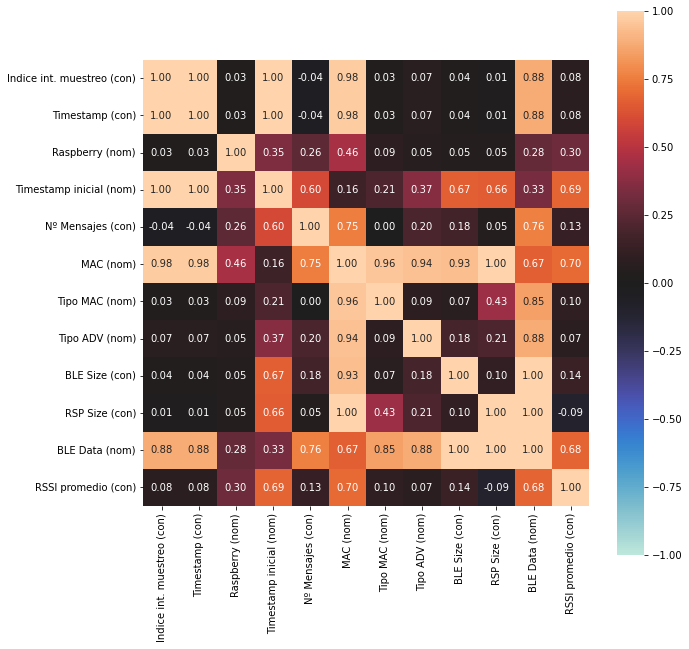

In [39]:
associations(data_20220712, figsize=(10, 10), mark_columns=True);
